In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# CycleGAN

#### Directory structure:
- **data/** contains the datasets.
    - **data/&lt;dataset&gt;/{train_A, train_B}/** contains training images for classes A and B.
    - **data/&lt;dataset&gt;/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.
- **images/** stores metadata and loss information of each CycleGAN run, as well as evaluation images.
    - **images/meta_data.json** contains the settings of the run.
    - **images/loss_output.csv** contains the various losses of the model, stored after every batch.
    - **images/{train_A, train_B, test_A, test_B}** contains intermediate evaluation images for each epoch, illustrating generator performance.
    - **images/tmp.png** shows example image translations from the current moment in training. This image updates in real time and can be used to see how the training converges.
- **saved_models** stores the generator and discriminator models resulting from each run, which are saved every 20 epochs.

Tomado de:
https://github.com/brainhack101/IntroDL/blob/master/notebooks/2019/Eklund/CycleGAN.ipynb

!rm -rf __pycache__

!wget -nc https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/requirements-gpu.txt

!pip install -r requirements-gpu.txt

In [2]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

import keras as ke
print(tf.__version__)
print(ke.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

1.14.0
2.2.4


Additional functions are contained in the `helper_functions.py` file. These mostly include code for loading the data and saving the resutls.

!wget https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/helper_funcs.py

In [3]:
from helper_funcs import *

If you have multiple GPUs you can select a single one of them by setting the visible CUDA device to 0, 1, ...

#### Load data

The dataset used for the run is **data/&lt;`image_folder`&gt;**.

In [4]:
image_folder = 'brain'
data = load_data(subfolder=image_folder)

### Model parameters

This CycleGAN implementation allows a lot of freedom on both the training parameters and the network architecture.

In [5]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

print(opt['A_train'].shape)
print(opt['B_train'].shape)

print(opt['CTFOSCAL_images'].shape)
print(len(opt['CTFOSCAL_image_names']))
print(opt['CTHEALTHY_images'].shape)
print(len(opt['CTHEALTHY_image_names']))

Image shape:  (256, 256, 1)
(502, 256, 256, 1)
(993, 256, 256, 1)
(73, 256, 256, 1)
73
(1568, 256, 256, 1)
1568


CylceGAN can be used both on paired and unpaired data. The `paired_data` setting affects the presentation of output images as explained above.

In [6]:
#opt['paired_data'] = True
opt['paired_data'] = False

#### Training parameters
- `lambda_ABA` and `lambda_BAB` set the importance of the cycle consistency losses in relation to the adversarial loss `lambda_adversarial`
- `learning_rate_D` and `learning_rate_G` are the learning rates for the discriminators and generators respectively.
- `generator_iterations` and `discriminator_iterations` represent how many times the generators or discriminators will be trained on every batch of images. This is very useful to keep the training of both systems balanced. In this case the discriminators become successful faster than the generators, so we account for this by training the generators 3 times on every batch of images.
- `synthetic_pool_size` sets the size of the image pool used for training the discriminators. The image pool has a certain probability of returning a synthetic image from previous iterations, thus forcing the discriminator to have a certain "memory". More information on this method can be found in [this paper](https://arxiv.org/abs/1612.07828).
- `beta_1` and `beta_2` are paremeters of the [Adam](https://arxiv.org/abs/1412.6980) optimizers used on the generators and discriminators.
- `batch_size` determines the number of images used for each update of the network weights. Due to the significant memory requirements of CycleGAN it is difficult to use a large batch size. For the small example dataset values between 1-30 may be possible.
- `epochs` sets the number of training epochs. Each epoch goes through all the training images once. The number of epochs necessary to train a model is therefore dependent on both the number of training images available and the batch size.

In [7]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 10  # Number of images per batch
opt['epochs'] = 25  # Choose multiples of 20 since the models are saved each 20th epoch

In [8]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

#### Architecture parameters
- `use_instance_normalization` is supposed to allow the selection of instance normalization or batch normalization layes. At the moment only instance normalization is implemented, so this option does not do anything.
- `use_dropout` and `use_bias` allows setting droupout layers in the generators and whether to use a bias term in the various convolutional layer in the genrators and discriminators.
- `use_linear_decay` applies linear decay on the learning rates of the generators and discriminators,   `decay_epoch`
- `use_patchgan` determines whether the discriminator evaluates the "realness" of images on a patch basis or on the whole. More information on PatchGAN can be found in [this paper](https://arxiv.org/abs/1611.07004).
- `use_resize_convolution` provides two ways to perfrom the upsampling in the generator, with significant differences in the results. More information can be found in [this article](https://distill.pub/2016/deconv-checkerboard/). Each has its advantages, and we have managed to get successful result with both methods
- `use_discriminator sigmoid` adds a sigmoid activation at the end of the discrimintator, forcing its output to the (0-1) range.

In [9]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator

In [10]:
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

### Model architecture

#### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. More information can be found in the appendix of the [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [11]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0, n):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0], name='add'+str(n))

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [12]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x, _)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### CasNet generator

In [13]:
#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=2, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [14]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [15]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

#model['G_A2B'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_A2B_model')
#model['G_B2A'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_B2A_model')

print("G_A2B")
model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0126 22:10:37.719886 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0126 22:10:37.721938 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0126 22:10:37.726427 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0126 22:10:38.126774 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 256, 256, 1)
G_A2B
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 262, 262, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 1600        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
instance_normalization_7 (Insta (None, 256, 256, 32) 64          conv2d_11[0][0]                  
______________________________________________________________________________________

#### Folders and configuration

In [16]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [17]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        print('\n')
        print('Epoch ---------------------', epoch, '/', opt['epochs'])
        print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        if opt['discriminator_iterations'] > 1:
            print('  Discriminator losses:')
            for i in range(opt['discriminator_iterations']):
                print('D_loss', D_loss[i])
        if opt['generator_iterations'] > 1:
            print('  Generator losses:')
            for i in range(opt['generator_iterations']):
                print('G_loss', G_loss[i])
        print('  Summary:')
        print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        print('D_loss: ', D_loss[-1])
        print('G_loss: ', G_loss[-1][0])
        print('reconstruction_loss: ', reconstruction_loss)
        print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True

        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 5 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [18]:
train(model, opt)

W0126 22:10:46.879299 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0126 22:10:46.925824 139992312256320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.





Epoch --------------------- 1 / 25
Loop index ---------------- 1 / 1000
  Generator losses:
G_loss [22.830915, 1.0778854, 1.1207107, 0.37975308, 0.4652029]
G_loss [19.283144, 0.96186364, 0.8883461, 0.35887152, 0.4221747]
G_loss [16.120537, 0.8234584, 0.7176178, 0.34534082, 0.36443463]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.68685627
G_loss:  16.120537
reconstruction_loss:  1.5410762
Elapsed time 0:01:16 : ETA in 219276 days, 21:45:52


Epoch --------------------- 1 / 25
Loop index ---------------- 11 / 1000
  Generator losses:
G_loss [13.814163, 0.70371586, 0.59775263, 0.36332908, 0.4361495]
G_loss [11.501509, 0.57993186, 0.49631763, 0.35094064, 0.3880728]
G_loss [9.592532, 0.4786721, 0.41107106, 0.33898628, 0.3561148]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.69439185
G_loss:  9.592532
reconstruction_loss:  0.88974315
Elapsed time 0:00:03 : ETA in 1:56:18


Epoch --------------------- 1 / 25
Loop index ---------------- 21 / 1000
  Generator losses:
G_loss [8.591224, 0.39



Epoch --------------------- 1 / 25
Loop index ---------------- 191 / 1000
  Generator losses:
G_loss [2.7332833, 0.074310504, 0.085606635, 0.4906938, 0.64341813]
G_loss [2.5431004, 0.070541404, 0.08129702, 0.47039, 0.5543262]
G_loss [2.449715, 0.07686786, 0.07840665, 0.45124993, 0.44571996]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.543558
G_loss:  2.449715
reconstruction_loss:  0.15527451
Elapsed time 0:00:55 : ETA in 1:58:46


Epoch --------------------- 1 / 25
Loop index ---------------- 201 / 1000
  Generator losses:
G_loss [2.727124, 0.09929915, 0.065630704, 0.55253935, 0.525286]
G_loss [2.6240325, 0.09338156, 0.06482117, 0.5407401, 0.50126517]
G_loss [2.543635, 0.090533614, 0.06400795, 0.5476855, 0.45053387]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.57061785
G_loss:  2.543635
reconstruction_loss:  0.15454157
Elapsed time 0:00:57 : ETA in 1:58:37


Epoch --------------------- 1 / 25
Loop index ---------------- 211 / 1000
  Generator losses:
G_loss [2.580262, 0.07927065,



Epoch --------------------- 1 / 25
Loop index ---------------- 381 / 1000
  Generator losses:
G_loss [1.8638496, 0.055951245, 0.05618621, 0.47104424, 0.27143094]
G_loss [2.370376, 0.07358516, 0.09111836, 0.45487595, 0.26846498]
G_loss [2.1721716, 0.08422467, 0.062663816, 0.44287372, 0.2604128]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5999204
G_loss:  2.1721716
reconstruction_loss:  0.1468885
Elapsed time 0:01:49 : ETA in 1:57:48


Epoch --------------------- 1 / 25
Loop index ---------------- 391 / 1000
  Generator losses:
G_loss [2.215837, 0.07830049, 0.061727475, 0.4720047, 0.3435526]
G_loss [2.0720053, 0.071496755, 0.05581324, 0.46517554, 0.3337298]
G_loss [1.9589136, 0.06615969, 0.051876307, 0.45191526, 0.32663834]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5449749
G_loss:  1.9589136
reconstruction_loss:  0.118035994
Elapsed time 0:01:52 : ETA in 1:57:43


Epoch --------------------- 1 / 25
Loop index ---------------- 401 / 1000
  Generator losses:
G_loss [2.1812139, 0.



Epoch --------------------- 1 / 25
Loop index ---------------- 571 / 1000
  Generator losses:
G_loss [1.961958, 0.062042076, 0.04994306, 0.48065767, 0.36144897]
G_loss [1.8622141, 0.055172056, 0.047957264, 0.4712866, 0.35963434]
G_loss [1.7841909, 0.051695727, 0.045359127, 0.4701662, 0.34347615]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5110948
G_loss:  1.7841909
reconstruction_loss:  0.097054854
Elapsed time 0:02:44 : ETA in 1:57:00


Epoch --------------------- 1 / 25
Loop index ---------------- 581 / 1000
  Generator losses:
G_loss [1.7347515, 0.052368037, 0.04159892, 0.45687017, 0.33821166]
G_loss [1.7927685, 0.060613804, 0.034869015, 0.45193425, 0.38600606]
G_loss [1.7014983, 0.054736197, 0.031404946, 0.45428842, 0.38579845]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5334089
G_loss:  1.7014983
reconstruction_loss:  0.08614114
Elapsed time 0:02:47 : ETA in 1:57:03


Epoch --------------------- 1 / 25
Loop index ---------------- 591 / 1000
  Generator losses:
G_loss [2.03



Epoch --------------------- 1 / 25
Loop index ---------------- 761 / 1000
  Generator losses:
G_loss [1.7375706, 0.059041016, 0.028824676, 0.45849496, 0.40041867]
G_loss [1.7715204, 0.06319769, 0.028706396, 0.46494108, 0.3875385]
G_loss [1.5693078, 0.043775775, 0.027864654, 0.46170682, 0.39119667]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4551555
G_loss:  1.5693078
reconstruction_loss:  0.07164043
Elapsed time 0:03:39 : ETA in 1:56:12


Epoch --------------------- 1 / 25
Loop index ---------------- 771 / 1000
  Generator losses:
G_loss [1.7356147, 0.042141117, 0.046161942, 0.44744253, 0.4051415]
G_loss [1.683559, 0.039336137, 0.044686772, 0.440475, 0.40285498]
G_loss [1.636061, 0.03630986, 0.04286211, 0.44033617, 0.40400505]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45517743
G_loss:  1.636061
reconstruction_loss:  0.07917197
Elapsed time 0:03:41 : ETA in 1:56:07


Epoch --------------------- 1 / 25
Loop index ---------------- 781 / 1000
  Generator losses:
G_loss [1.4074428



Epoch --------------------- 1 / 25
Loop index ---------------- 951 / 1000
  Generator losses:
G_loss [1.6985408, 0.05188743, 0.032668192, 0.39552397, 0.45746055]
G_loss [1.6919445, 0.058119923, 0.029149886, 0.4011732, 0.41807318]
G_loss [1.5179557, 0.043806877, 0.02710843, 0.3959643, 0.41283822]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48241836
G_loss:  1.5179557
reconstruction_loss:  0.07091531
Elapsed time 0:04:33 : ETA in 1:55:15


Epoch --------------------- 1 / 25
Loop index ---------------- 961 / 1000
  Generator losses:
G_loss [1.5390071, 0.041689865, 0.030607384, 0.40899006, 0.40704456]
G_loss [1.6105784, 0.043353606, 0.039670877, 0.3891986, 0.39113486]
G_loss [1.5995586, 0.04400494, 0.03516295, 0.40838376, 0.39949593]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47402722
G_loss:  1.5995586
reconstruction_loss:  0.07916789
Elapsed time 0:04:36 : ETA in 1:55:11


Epoch --------------------- 1 / 25
Loop index ---------------- 971 / 1000
  Generator losses:
G_loss [2.067



Epoch --------------------- 2 / 25
Loop index ---------------- 141 / 1000
  Generator losses:
G_loss [1.7944657, 0.056616057, 0.031050742, 0.42308116, 0.4947165]
G_loss [1.8916926, 0.0682377, 0.03150852, 0.40661415, 0.48761624]
G_loss [1.7027881, 0.051360577, 0.033287372, 0.41214925, 0.44415933]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4175145
G_loss:  1.7027881
reconstruction_loss:  0.08464795
Elapsed time 0:05:28 : ETA in 1:54:27


Epoch --------------------- 2 / 25
Loop index ---------------- 151 / 1000
  Generator losses:
G_loss [1.5177813, 0.037329394, 0.0441223, 0.38223746, 0.32102674]
G_loss [1.5025529, 0.038757052, 0.043047912, 0.36412585, 0.3203775]
G_loss [1.654305, 0.04447812, 0.052547496, 0.37590355, 0.30814528]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5874816
G_loss:  1.654305
reconstruction_loss:  0.09702562
Elapsed time 0:05:31 : ETA in 1:54:23


Epoch --------------------- 2 / 25
Loop index ---------------- 161 / 1000
  Generator losses:
G_loss [1.8669604,



Epoch --------------------- 2 / 25
Loop index ---------------- 331 / 1000
  Generator losses:
G_loss [1.7065251, 0.055226386, 0.021345671, 0.3708431, 0.5699613]
G_loss [1.8002923, 0.061625324, 0.022423197, 0.37482268, 0.58498424]
G_loss [1.6338159, 0.047498044, 0.021942172, 0.36642233, 0.5729914]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.43525177
G_loss:  1.6338159
reconstruction_loss:  0.069440216
Elapsed time 0:06:23 : ETA in 1:53:29


Epoch --------------------- 2 / 25
Loop index ---------------- 341 / 1000
  Generator losses:
G_loss [1.6796272, 0.049920302, 0.043059587, 0.39912796, 0.3507003]
G_loss [1.6299253, 0.041990597, 0.047857147, 0.37879443, 0.35265335]
G_loss [1.5225337, 0.037694048, 0.039620064, 0.39927724, 0.35011527]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.530596
G_loss:  1.5225337
reconstruction_loss:  0.07731411
Elapsed time 0:06:26 : ETA in 1:53:28


Epoch --------------------- 2 / 25
Loop index ---------------- 351 / 1000
  Generator losses:
G_loss [1.5



Epoch --------------------- 2 / 25
Loop index ---------------- 521 / 1000
  Generator losses:
G_loss [1.498381, 0.037275575, 0.03397709, 0.35237256, 0.43348178]
G_loss [1.4965464, 0.04000176, 0.03153332, 0.35647038, 0.42472515]
G_loss [1.3961725, 0.032249223, 0.029669559, 0.35310116, 0.42388353]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52055657
G_loss:  1.3961725
reconstruction_loss:  0.06191878
Elapsed time 0:07:17 : ETA in 1:52:35


Epoch --------------------- 2 / 25
Loop index ---------------- 531 / 1000
  Generator losses:
G_loss [1.5773902, 0.045293868, 0.039836735, 0.3289416, 0.3971426]
G_loss [1.5330404, 0.04377943, 0.037876263, 0.32360247, 0.392881]
G_loss [1.4716303, 0.041604027, 0.03417941, 0.32726303, 0.38653287]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5389376
G_loss:  1.4716303
reconstruction_loss:  0.07578344
Elapsed time 0:07:20 : ETA in 1:52:32


Epoch --------------------- 2 / 25
Loop index ---------------- 541 / 1000
  Generator losses:
G_loss [1.4969, 0



Epoch --------------------- 2 / 25
Loop index ---------------- 711 / 1000
  Generator losses:
G_loss [1.3841373, 0.036305837, 0.028335739, 0.3616715, 0.37604985]
G_loss [1.3510363, 0.03533218, 0.027370205, 0.36606055, 0.35795188]
G_loss [1.3004742, 0.033016693, 0.028302213, 0.3424113, 0.34487373]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.53251165
G_loss:  1.3004742
reconstruction_loss:  0.061318904
Elapsed time 0:08:12 : ETA in 1:51:38


Epoch --------------------- 2 / 25
Loop index ---------------- 721 / 1000
  Generator losses:
G_loss [1.5559125, 0.03748899, 0.038183685, 0.38558763, 0.41359812]
G_loss [1.5875823, 0.038436085, 0.042761713, 0.3661018, 0.40950245]
G_loss [1.6948884, 0.036626533, 0.053442944, 0.39344865, 0.40074492]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5003706
G_loss:  1.6948884
reconstruction_loss:  0.09006947
Elapsed time 0:08:15 : ETA in 1:51:35


Epoch --------------------- 2 / 25
Loop index ---------------- 731 / 1000
  Generator losses:
G_loss [1.6



Epoch --------------------- 2 / 25
Loop index ---------------- 901 / 1000
  Generator losses:
G_loss [1.5385704, 0.03661961, 0.03528289, 0.40337116, 0.41617423]
G_loss [1.5120937, 0.036353864, 0.032804124, 0.4141572, 0.40635657]
G_loss [1.4983689, 0.036879867, 0.032136623, 0.40719444, 0.40100956]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5048665
G_loss:  1.4983689
reconstruction_loss:  0.06901649
Elapsed time 0:09:06 : ETA in 1:50:42


Epoch --------------------- 2 / 25
Loop index ---------------- 911 / 1000
  Generator losses:
G_loss [1.7675905, 0.057601325, 0.033239506, 0.4492117, 0.40997046]
G_loss [1.84947, 0.0650112, 0.033883277, 0.47907725, 0.38144806]
G_loss [1.7168331, 0.044881325, 0.042331506, 0.46559423, 0.37911057]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49869588
G_loss:  1.7168331
reconstruction_loss:  0.08721283
Elapsed time 0:09:09 : ETA in 1:50:40


Epoch --------------------- 2 / 25
Loop index ---------------- 921 / 1000
  Generator losses:
G_loss [1.40950



Epoch --------------------- 3 / 25
Loop index ---------------- 91 / 1000
  Generator losses:
G_loss [1.7204899, 0.047247797, 0.023332749, 0.472431, 0.5422534]
G_loss [1.7954836, 0.058316477, 0.022271657, 0.4691352, 0.52046704]
G_loss [1.5979291, 0.039688293, 0.02199708, 0.4671012, 0.5139742]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3492525
G_loss:  1.5979291
reconstruction_loss:  0.061685372
Elapsed time 0:10:01 : ETA in 1:49:50


Epoch --------------------- 3 / 25
Loop index ---------------- 101 / 1000
  Generator losses:
G_loss [1.6318169, 0.042321574, 0.03532032, 0.39911848, 0.45627952]
G_loss [1.636632, 0.041582745, 0.03748839, 0.40013137, 0.44578928]
G_loss [1.5551369, 0.04027713, 0.03324439, 0.3810775, 0.43884414]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5098127
G_loss:  1.5551369
reconstruction_loss:  0.073521525
Elapsed time 0:10:04 : ETA in 1:49:49


Epoch --------------------- 3 / 25
Loop index ---------------- 111 / 1000
  Generator losses:
G_loss [1.7609923, 0



Epoch --------------------- 3 / 25
Loop index ---------------- 281 / 1000
  Generator losses:
G_loss [1.4169636, 0.035285782, 0.02882846, 0.39201784, 0.38380334]
G_loss [1.3830099, 0.039010994, 0.023887426, 0.39577967, 0.35824612]
G_loss [1.2978377, 0.03159529, 0.022105569, 0.39225692, 0.3685723]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.51800805
G_loss:  1.2978377
reconstruction_loss:  0.053700857
Elapsed time 0:10:56 : ETA in 1:48:55


Epoch --------------------- 3 / 25
Loop index ---------------- 291 / 1000
  Generator losses:
G_loss [1.544774, 0.036693733, 0.027311485, 0.42225757, 0.48246425]
G_loss [1.4056841, 0.036098193, 0.023792455, 0.4221581, 0.38461944]
G_loss [1.3015193, 0.036732234, 0.021640675, 0.4198981, 0.2978921]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.433344
G_loss:  1.3015193
reconstruction_loss:  0.058372907
Elapsed time 0:10:59 : ETA in 1:48:52


Epoch --------------------- 3 / 25
Loop index ---------------- 301 / 1000
  Generator losses:
G_loss [1.626



Epoch --------------------- 3 / 25
Loop index ---------------- 471 / 1000
  Generator losses:
G_loss [1.2591218, 0.025525814, 0.030652195, 0.25626963, 0.44107208]
G_loss [1.2465012, 0.023313394, 0.03601225, 0.21576028, 0.43748456]
G_loss [1.1708692, 0.02138782, 0.029046778, 0.23711228, 0.429411]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.6643144
G_loss:  1.1708692
reconstruction_loss:  0.050434597
Elapsed time 0:11:50 : ETA in 1:47:59


Epoch --------------------- 3 / 25
Loop index ---------------- 481 / 1000
  Generator losses:
G_loss [1.5500836, 0.038610913, 0.047254167, 0.30254117, 0.38889176]
G_loss [1.4277176, 0.033878766, 0.038650334, 0.31307855, 0.38934806]
G_loss [1.3298032, 0.03209719, 0.030611595, 0.31535718, 0.3873582]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.59290653
G_loss:  1.3298032
reconstruction_loss:  0.06270879
Elapsed time 0:11:53 : ETA in 1:47:55


Epoch --------------------- 3 / 25
Loop index ---------------- 491 / 1000
  Generator losses:
G_loss [1.48



Epoch --------------------- 3 / 25
Loop index ---------------- 661 / 1000
  Generator losses:
G_loss [1.6501632, 0.03860069, 0.02586194, 0.45832062, 0.54721624]
G_loss [1.6410306, 0.043632336, 0.020547489, 0.4603797, 0.53885263]
G_loss [1.4925506, 0.0344022, 0.016573103, 0.44671106, 0.5360866]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35457855
G_loss:  1.4925506
reconstruction_loss:  0.0509753
Elapsed time 0:12:45 : ETA in 1:47:03


Epoch --------------------- 3 / 25
Loop index ---------------- 671 / 1000
  Generator losses:
G_loss [1.4922274, 0.03532776, 0.029918125, 0.4478379, 0.3919307]
G_loss [1.7854483, 0.051905595, 0.052418374, 0.37581676, 0.36639196]
G_loss [1.5442064, 0.04033176, 0.03526046, 0.42894882, 0.35933536]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46736026
G_loss:  1.5442064
reconstruction_loss:  0.07559222
Elapsed time 0:12:48 : ETA in 1:47:01


Epoch --------------------- 3 / 25
Loop index ---------------- 681 / 1000
  Generator losses:
G_loss [1.9313442,



Epoch --------------------- 3 / 25
Loop index ---------------- 851 / 1000
  Generator losses:
G_loss [1.3503337, 0.029333174, 0.02726465, 0.35105592, 0.43329954]
G_loss [1.2713339, 0.02625846, 0.022272017, 0.35467708, 0.43135214]
G_loss [1.244218, 0.0264189, 0.020764407, 0.3485361, 0.42384887]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48774725
G_loss:  1.244218
reconstruction_loss:  0.047183305
Elapsed time 0:13:39 : ETA in 1:46:08


Epoch --------------------- 3 / 25
Loop index ---------------- 861 / 1000
  Generator losses:
G_loss [1.5602987, 0.03954075, 0.038228672, 0.38029546, 0.40230888]
G_loss [1.5489506, 0.040874165, 0.035453785, 0.38363808, 0.402033]
G_loss [1.5375726, 0.042896908, 0.034807898, 0.38086596, 0.3796587]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52101994
G_loss:  1.5375726
reconstruction_loss:  0.0777048
Elapsed time 0:13:42 : ETA in 1:46:05


Epoch --------------------- 3 / 25
Loop index ---------------- 871 / 1000
  Generator losses:
G_loss [1.421937,



Epoch --------------------- 4 / 25
Loop index ---------------- 41 / 1000
  Generator losses:
G_loss [1.3792399, 0.03120054, 0.01833179, 0.4034688, 0.48044783]
G_loss [1.3706058, 0.03200246, 0.015815165, 0.41153544, 0.48089415]
G_loss [1.4091686, 0.04096607, 0.013496533, 0.41360134, 0.45094123]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41124052
G_loss:  1.4091686
reconstruction_loss:  0.054462604
Elapsed time 0:14:34 : ETA in 1:45:15


Epoch --------------------- 4 / 25
Loop index ---------------- 51 / 1000
  Generator losses:
G_loss [1.4993908, 0.039091118, 0.032779645, 0.39296544, 0.3877178]
G_loss [1.4435943, 0.034351967, 0.037445437, 0.3521157, 0.37350464]
G_loss [1.3791478, 0.036699258, 0.027767599, 0.37949657, 0.35498258]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49298257
G_loss:  1.3791478
reconstruction_loss:  0.06446686
Elapsed time 0:14:37 : ETA in 1:45:11


Epoch --------------------- 4 / 25
Loop index ---------------- 61 / 1000
  Generator losses:
G_loss [1.50303



Epoch --------------------- 4 / 25
Loop index ---------------- 231 / 1000
  Generator losses:
G_loss [1.533863, 0.037674554, 0.028414454, 0.40731654, 0.46565643]
G_loss [1.4594316, 0.030896515, 0.027608141, 0.40583053, 0.46855468]
G_loss [1.4986626, 0.03214445, 0.03201239, 0.39652467, 0.46056953]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46160007
G_loss:  1.4986626
reconstruction_loss:  0.064156845
Elapsed time 0:15:29 : ETA in 1:44:19


Epoch --------------------- 4 / 25
Loop index ---------------- 241 / 1000
  Generator losses:
G_loss [1.7707199, 0.062585875, 0.03063621, 0.4169671, 0.42153206]
G_loss [1.5972275, 0.04794122, 0.02928245, 0.42116562, 0.4038252]
G_loss [1.4680653, 0.039592136, 0.024757091, 0.4221909, 0.4023822]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48222983
G_loss:  1.4680653
reconstruction_loss:  0.06434923
Elapsed time 0:15:31 : ETA in 1:44:15


Epoch --------------------- 4 / 25
Loop index ---------------- 251 / 1000
  Generator losses:
G_loss [1.25771



Epoch --------------------- 4 / 25
Loop index ---------------- 421 / 1000
  Generator losses:
G_loss [1.6949526, 0.05913668, 0.038286917, 0.34263045, 0.3780862]
G_loss [1.5996296, 0.061673563, 0.032056686, 0.35118532, 0.3111419]
G_loss [1.3851247, 0.036208153, 0.03420973, 0.35150743, 0.3294384]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.56856644
G_loss:  1.3851247
reconstruction_loss:  0.07041788
Elapsed time 0:16:23 : ETA in 1:43:24


Epoch --------------------- 4 / 25
Loop index ---------------- 431 / 1000
  Generator losses:
G_loss [1.3343189, 0.026422093, 0.031104485, 0.2824331, 0.47661996]
G_loss [1.2183683, 0.023890305, 0.025680566, 0.28571272, 0.4369468]
G_loss [1.2017193, 0.026402075, 0.028865408, 0.2757643, 0.37328014]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.50916076
G_loss:  1.2017193
reconstruction_loss:  0.055267483
Elapsed time 0:16:26 : ETA in 1:43:22


Epoch --------------------- 4 / 25
Loop index ---------------- 441 / 1000
  Generator losses:
G_loss [1.594



Epoch --------------------- 4 / 25
Loop index ---------------- 611 / 1000
  Generator losses:
G_loss [1.44604, 0.031057436, 0.03038117, 0.35303047, 0.47862348]
G_loss [1.3762872, 0.029301222, 0.024947153, 0.35890424, 0.47489914]
G_loss [1.3377515, 0.02766335, 0.024109613, 0.35691383, 0.46310806]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45166087
G_loss:  1.3377515
reconstruction_loss:  0.051772963
Elapsed time 0:17:18 : ETA in 1:42:28


Epoch --------------------- 4 / 25
Loop index ---------------- 621 / 1000
  Generator losses:
G_loss [1.3903682, 0.030834626, 0.023177896, 0.40498582, 0.44525713]
G_loss [1.3477385, 0.028473224, 0.021677805, 0.4060474, 0.44018087]
G_loss [1.33731, 0.02965354, 0.021510351, 0.39470387, 0.43096718]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4408543
G_loss:  1.33731
reconstruction_loss:  0.05116389
Elapsed time 0:17:20 : ETA in 1:42:25


Epoch --------------------- 4 / 25
Loop index ---------------- 631 / 1000
  Generator losses:
G_loss [1.454157



Epoch --------------------- 4 / 25
Loop index ---------------- 801 / 1000
  Generator losses:
G_loss [1.3146783, 0.029765349, 0.030333608, 0.3091213, 0.40456742]
G_loss [1.3473077, 0.028044483, 0.03713692, 0.30467227, 0.3908214]
G_loss [1.2022429, 0.0273936, 0.024385149, 0.30232587, 0.3821296]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5410429
G_loss:  1.2022429
reconstruction_loss:  0.05177875
Elapsed time 0:18:12 : ETA in 1:41:33


Epoch --------------------- 4 / 25
Loop index ---------------- 811 / 1000
  Generator losses:
G_loss [1.2220368, 0.029222036, 0.017550047, 0.31211498, 0.442201]
G_loss [1.1508356, 0.0227344, 0.01742431, 0.30947796, 0.43977055]
G_loss [1.2238181, 0.026326444, 0.020815909, 0.30986738, 0.44252723]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52220786
G_loss:  1.2238181
reconstruction_loss:  0.047142353
Elapsed time 0:18:15 : ETA in 1:41:30


Epoch --------------------- 4 / 25
Loop index ---------------- 821 / 1000
  Generator losses:
G_loss [1.5192037



Epoch --------------------- 4 / 25
Loop index ---------------- 991 / 1000
  Generator losses:
G_loss [1.4408764, 0.038119994, 0.01664389, 0.4201212, 0.4731163]
G_loss [1.3969059, 0.033653654, 0.016301354, 0.42300278, 0.474353]
G_loss [1.4227548, 0.03841275, 0.014997749, 0.41670585, 0.47194394]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41103876
G_loss:  1.4227548
reconstruction_loss:  0.0534105
Elapsed time 0:19:07 : ETA in 1:40:38

 
 -------------------------Saving images for epoch 4 ------------------------- 
 



Epoch --------------------- 5 / 25
Loop index ---------------- 1 / 1000
  Generator losses:
G_loss [1.5509825, 0.045315843, 0.024008842, 0.42059407, 0.43714157]
G_loss [1.4554694, 0.037219107, 0.022437006, 0.4284606, 0.43044764]
G_loss [1.3207017, 0.027143532, 0.020657286, 0.42186204, 0.4208316]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4213264
G_loss:  1.3207017
reconstruction_loss:  0.047800817
Elapsed time 0:19:10 : ETA in 1:40:37


Epoch --------------------



Epoch --------------------- 5 / 25
Loop index ---------------- 181 / 1000
  Generator losses:
G_loss [1.4587233, 0.032623187, 0.028100803, 0.38030607, 0.47117728]
G_loss [1.3600775, 0.02967738, 0.024233619, 0.3766243, 0.44434318]
G_loss [1.323627, 0.029611528, 0.023842866, 0.37387913, 0.4152039]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.43431845
G_loss:  1.323627
reconstruction_loss:  0.05345439
Elapsed time 0:20:02 : ETA in 1:39:45


Epoch --------------------- 5 / 25
Loop index ---------------- 191 / 1000
  Generator losses:
G_loss [1.4804561, 0.036781214, 0.022979354, 0.4260385, 0.45681196]
G_loss [1.5381238, 0.046202604, 0.023347313, 0.42721844, 0.41540623]
G_loss [1.4069266, 0.04605943, 0.017459746, 0.42467746, 0.34705728]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45306927
G_loss:  1.4069266
reconstruction_loss:  0.06351918
Elapsed time 0:20:05 : ETA in 1:39:42


Epoch --------------------- 5 / 25
Loop index ---------------- 201 / 1000
  Generator losses:
G_loss [1.374



Epoch --------------------- 5 / 25
Loop index ---------------- 371 / 1000
  Generator losses:
G_loss [1.4245405, 0.031342935, 0.023011744, 0.40741467, 0.47357902]
G_loss [1.3924218, 0.03131338, 0.021837717, 0.41057292, 0.45033804]
G_loss [1.3184283, 0.028361708, 0.018933356, 0.40017334, 0.44530433]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4006592
G_loss:  1.3184283
reconstruction_loss:  0.047295064
Elapsed time 0:20:56 : ETA in 1:38:50


Epoch --------------------- 5 / 25
Loop index ---------------- 381 / 1000
  Generator losses:
G_loss [1.4717855, 0.034816667, 0.019032033, 0.45227122, 0.48102736]
G_loss [1.4778388, 0.035604764, 0.02008293, 0.44858852, 0.4723733]
G_loss [1.6577537, 0.05137524, 0.026358712, 0.44588122, 0.43453294]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3937294
G_loss:  1.6577537
reconstruction_loss:  0.07773395
Elapsed time 0:20:59 : ETA in 1:38:47


Epoch --------------------- 5 / 25
Loop index ---------------- 391 / 1000
  Generator losses:
G_loss [1.7



Epoch --------------------- 5 / 25
Loop index ---------------- 561 / 1000
  Generator losses:
G_loss [1.409238, 0.028798867, 0.030412758, 0.3802458, 0.4368759]
G_loss [1.398565, 0.032119464, 0.028485399, 0.3802127, 0.41230375]
G_loss [1.4560397, 0.03067717, 0.036400076, 0.3705975, 0.41466966]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48332718
G_loss:  1.4560397
reconstruction_loss:  0.06707725
Elapsed time 0:21:51 : ETA in 1:37:55


Epoch --------------------- 5 / 25
Loop index ---------------- 571 / 1000
  Generator losses:
G_loss [1.8645864, 0.038438566, 0.06727733, 0.39223215, 0.4151953]
G_loss [1.5438433, 0.037438694, 0.039654013, 0.37369925, 0.39921683]
G_loss [1.506556, 0.037812393, 0.03490854, 0.3698386, 0.40950808]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.51623785
G_loss:  1.506556
reconstruction_loss:  0.07272093
Elapsed time 0:21:54 : ETA in 1:37:52


Epoch --------------------- 5 / 25
Loop index ---------------- 581 / 1000
  Generator losses:
G_loss [1.7764091, 



Epoch --------------------- 5 / 25
Loop index ---------------- 751 / 1000
  Generator losses:
G_loss [1.6131159, 0.04145941, 0.025390556, 0.43169442, 0.5129218]
G_loss [1.6018038, 0.045302756, 0.020349162, 0.44335896, 0.50192577]
G_loss [1.4642696, 0.034719277, 0.020648729, 0.43128806, 0.4793015]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3796896
G_loss:  1.4642696
reconstruction_loss:  0.055368006
Elapsed time 0:22:45 : ETA in 1:37:01


Epoch --------------------- 5 / 25
Loop index ---------------- 761 / 1000
  Generator losses:
G_loss [1.6292176, 0.036716305, 0.03604477, 0.42610162, 0.4755053]
G_loss [1.5638311, 0.03721496, 0.031740796, 0.41075554, 0.46351808]
G_loss [1.704695, 0.050347913, 0.035477318, 0.3928166, 0.45362607]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47704473
G_loss:  1.704695
reconstruction_loss:  0.085825235
Elapsed time 0:22:48 : ETA in 1:36:58


Epoch --------------------- 5 / 25
Loop index ---------------- 771 / 1000
  Generator losses:
G_loss [1.8774



Epoch --------------------- 5 / 25
Loop index ---------------- 941 / 1000
  Generator losses:
G_loss [1.3829056, 0.028957207, 0.030417804, 0.34519106, 0.4439644]
G_loss [1.3380086, 0.028255725, 0.02855128, 0.3371526, 0.43278605]
G_loss [1.3058704, 0.028498074, 0.02531701, 0.33228475, 0.43543488]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4665823
G_loss:  1.3058704
reconstruction_loss:  0.05381508
Elapsed time 0:23:40 : ETA in 1:36:06


Epoch --------------------- 5 / 25
Loop index ---------------- 951 / 1000
  Generator losses:
G_loss [1.3850946, 0.037365973, 0.028369155, 0.32737368, 0.4003697]
G_loss [1.3161137, 0.03431373, 0.025018781, 0.32251343, 0.40027508]
G_loss [1.2277207, 0.031172048, 0.023546861, 0.3146897, 0.3658419]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5268744
G_loss:  1.2277207
reconstruction_loss:  0.05471891
Elapsed time 0:23:43 : ETA in 1:36:03


Epoch --------------------- 5 / 25
Loop index ---------------- 961 / 1000
  Generator losses:
G_loss [1.436052



Epoch --------------------- 6 / 25
Loop index ---------------- 121 / 1000
  Generator losses:
G_loss [1.4518878, 0.03623928, 0.027854707, 0.34991723, 0.46103072]
G_loss [1.4006197, 0.032718994, 0.026844505, 0.3633527, 0.4416321]
G_loss [1.311348, 0.029745381, 0.026314432, 0.35371, 0.39703977]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5000026
G_loss:  1.311348
reconstruction_loss:  0.056059815
Elapsed time 0:25:07 : ETA in 1:37:33


Epoch --------------------- 6 / 25
Loop index ---------------- 131 / 1000
  Generator losses:
G_loss [1.4681542, 0.035568226, 0.020948684, 0.3963109, 0.5066742]
G_loss [1.3495736, 0.030890625, 0.016858086, 0.3789504, 0.49313608]
G_loss [1.2857497, 0.027793687, 0.014672053, 0.37709722, 0.48399502]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40498987
G_loss:  1.2857497
reconstruction_loss:  0.04246574
Elapsed time 0:25:10 : ETA in 1:37:30


Epoch --------------------- 6 / 25
Loop index ---------------- 141 / 1000
  Generator losses:
G_loss [1.3647251



Epoch --------------------- 6 / 25
Loop index ---------------- 311 / 1000
  Generator losses:
G_loss [1.3364588, 0.020786578, 0.022330593, 0.3707487, 0.5345384]
G_loss [1.1866589, 0.019900452, 0.01007415, 0.35526118, 0.5316516]
G_loss [1.1706712, 0.01996271, 0.0126989605, 0.31706822, 0.52698636]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.39281982
G_loss:  1.1706712
reconstruction_loss:  0.03266167
Elapsed time 0:26:02 : ETA in 1:36:32


Epoch --------------------- 6 / 25
Loop index ---------------- 321 / 1000
  Generator losses:
G_loss [1.5141612, 0.031574484, 0.035648353, 0.42802373, 0.4139092]
G_loss [1.4329402, 0.030769408, 0.029940775, 0.4282728, 0.3975656]
G_loss [1.3287635, 0.031601116, 0.023011062, 0.42147154, 0.3611701]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47782576
G_loss:  1.3287635
reconstruction_loss:  0.05461218
Elapsed time 0:26:05 : ETA in 1:36:28


Epoch --------------------- 6 / 25
Loop index ---------------- 331 / 1000
  Generator losses:
G_loss [1.4080



Epoch --------------------- 6 / 25
Loop index ---------------- 501 / 1000
  Generator losses:
G_loss [1.3828189, 0.028737482, 0.023888715, 0.42472702, 0.43182993]
G_loss [1.3407245, 0.027583634, 0.021483997, 0.42206568, 0.42798248]
G_loss [1.362474, 0.031883024, 0.020313075, 0.41979703, 0.42071596]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44038647
G_loss:  1.362474
reconstruction_loss:  0.0521961
Elapsed time 0:26:56 : ETA in 1:35:31


Epoch --------------------- 6 / 25
Loop index ---------------- 511 / 1000
  Generator losses:
G_loss [1.2337892, 0.028695608, 0.02363437, 0.33665055, 0.37383887]
G_loss [1.1500572, 0.023583377, 0.022536952, 0.33070463, 0.35814932]
G_loss [1.1381454, 0.022889847, 0.023963675, 0.32538506, 0.34422523]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5484247
G_loss:  1.1381454
reconstruction_loss:  0.04685352
Elapsed time 0:26:59 : ETA in 1:35:27


Epoch --------------------- 6 / 25
Loop index ---------------- 521 / 1000
  Generator losses:
G_loss [1.2



Epoch --------------------- 6 / 25
Loop index ---------------- 691 / 1000
  Generator losses:
G_loss [1.2222426, 0.024784278, 0.020321105, 0.31927782, 0.45191103]
G_loss [1.2004353, 0.022619491, 0.022085201, 0.32110113, 0.43228722]
G_loss [1.3030514, 0.023188647, 0.03438607, 0.30747572, 0.4198285]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48548317
G_loss:  1.3030514
reconstruction_loss:  0.057574715
Elapsed time 0:27:51 : ETA in 1:34:31


Epoch --------------------- 6 / 25
Loop index ---------------- 701 / 1000
  Generator losses:
G_loss [1.3744488, 0.029586226, 0.033502877, 0.31966004, 0.42389774]
G_loss [1.2508225, 0.027420605, 0.024040902, 0.31562987, 0.4205776]
G_loss [1.2021291, 0.025831997, 0.021581728, 0.3155604, 0.41243148]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52581257
G_loss:  1.2021291
reconstruction_loss:  0.047413725
Elapsed time 0:27:54 : ETA in 1:34:28


Epoch --------------------- 6 / 25
Loop index ---------------- 711 / 1000
  Generator losses:
G_loss [



Epoch --------------------- 6 / 25
Loop index ---------------- 881 / 1000
  Generator losses:
G_loss [1.4568278, 0.03148611, 0.02571421, 0.46359158, 0.42123303]
G_loss [1.4049046, 0.029426226, 0.025764141, 0.43926987, 0.41373092]
G_loss [1.3871802, 0.029562179, 0.023940857, 0.4444836, 0.4076662]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4232899
G_loss:  1.3871802
reconstruction_loss:  0.053503036
Elapsed time 0:28:46 : ETA in 1:33:31


Epoch --------------------- 6 / 25
Loop index ---------------- 891 / 1000
  Generator losses:
G_loss [1.3675934, 0.02950109, 0.024610775, 0.36362305, 0.46285176]
G_loss [1.3263359, 0.030060241, 0.021425545, 0.36242473, 0.4490533]
G_loss [1.2183601, 0.024006536, 0.018764121, 0.35676438, 0.43388915]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4676812
G_loss:  1.2183601
reconstruction_loss:  0.042770658
Elapsed time 0:28:48 : ETA in 1:33:28


Epoch --------------------- 6 / 25
Loop index ---------------- 901 / 1000
  Generator losses:
G_loss [1.26



Epoch --------------------- 7 / 25
Loop index ---------------- 71 / 1000
  Generator losses:
G_loss [1.5435636, 0.035340093, 0.026940519, 0.4293067, 0.49145085]
G_loss [1.4024708, 0.027092427, 0.023225177, 0.41645488, 0.48283988]
G_loss [1.3557191, 0.027332902, 0.02057793, 0.40461698, 0.47199383]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38797417
G_loss:  1.3557191
reconstruction_loss:  0.047910832
Elapsed time 0:29:41 : ETA in 1:32:33


Epoch --------------------- 7 / 25
Loop index ---------------- 81 / 1000
  Generator losses:
G_loss [1.4438192, 0.03475374, 0.01623738, 0.43935004, 0.49455795]
G_loss [1.4434812, 0.031680927, 0.019442841, 0.43557507, 0.4966685]
G_loss [1.4243577, 0.032576922, 0.019335598, 0.41873327, 0.48649913]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38858974
G_loss:  1.4243577
reconstruction_loss:  0.05191252
Elapsed time 0:29:44 : ETA in 1:32:30


Epoch --------------------- 7 / 25
Loop index ---------------- 91 / 1000
  Generator losses:
G_loss [1.400



Epoch --------------------- 7 / 25
Loop index ---------------- 261 / 1000
  Generator losses:
G_loss [1.5070148, 0.03119862, 0.027219286, 0.4262941, 0.49654156]
G_loss [1.4315546, 0.029113714, 0.02215213, 0.4254384, 0.4934577]
G_loss [1.507657, 0.038913872, 0.021063363, 0.4203272, 0.48755747]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38541275
G_loss:  1.507657
reconstruction_loss:  0.059977233
Elapsed time 0:30:35 : ETA in 1:31:34


Epoch --------------------- 7 / 25
Loop index ---------------- 271 / 1000
  Generator losses:
G_loss [1.420489, 0.03416538, 0.024319906, 0.40478843, 0.4308477]
G_loss [1.4508734, 0.028540215, 0.037611164, 0.3709097, 0.41844982]
G_loss [1.4842484, 0.030283922, 0.036160834, 0.408125, 0.41167575]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44545245
G_loss:  1.4842484
reconstruction_loss:  0.066444755
Elapsed time 0:30:38 : ETA in 1:31:31


Epoch --------------------- 7 / 25
Loop index ---------------- 281 / 1000
  Generator losses:
G_loss [1.292898, 



Epoch --------------------- 7 / 25
Loop index ---------------- 451 / 1000
  Generator losses:
G_loss [1.216157, 0.018449785, 0.01829857, 0.3260795, 0.52259386]
G_loss [1.2038308, 0.01999053, 0.016774023, 0.32015058, 0.5160347]
G_loss [1.1720518, 0.019259188, 0.016126782, 0.31634584, 0.50184625]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46080953
G_loss:  1.1720518
reconstruction_loss:  0.03538597
Elapsed time 0:31:30 : ETA in 1:30:35


Epoch --------------------- 7 / 25
Loop index ---------------- 461 / 1000
  Generator losses:
G_loss [1.2440077, 0.026531596, 0.024119627, 0.35552847, 0.38196704]
G_loss [1.2641659, 0.027977118, 0.028799921, 0.32833028, 0.3680653]
G_loss [1.3269117, 0.031866334, 0.030701894, 0.35313132, 0.34809807]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.53045446
G_loss:  1.3269117
reconstruction_loss:  0.06256823
Elapsed time 0:31:33 : ETA in 1:30:32


Epoch --------------------- 7 / 25
Loop index ---------------- 471 / 1000
  Generator losses:
G_loss [1.56



Epoch --------------------- 7 / 25
Loop index ---------------- 641 / 1000
  Generator losses:
G_loss [1.421672, 0.034945402, 0.030088056, 0.39250854, 0.37882885]
G_loss [1.3905616, 0.033923075, 0.030294925, 0.38450733, 0.36387426]
G_loss [1.3901136, 0.034726996, 0.03164323, 0.3787199, 0.34769145]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49526316
G_loss:  1.3901136
reconstruction_loss:  0.06637023
Elapsed time 0:32:24 : ETA in 1:29:36


Epoch --------------------- 7 / 25
Loop index ---------------- 651 / 1000
  Generator losses:
G_loss [1.4261968, 0.029714042, 0.034641482, 0.31294137, 0.46970016]
G_loss [1.2137355, 0.02351407, 0.022166435, 0.30120334, 0.4557271]
G_loss [1.1690129, 0.0208013, 0.02245115, 0.29399547, 0.44249296]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49996406
G_loss:  1.1690129
reconstruction_loss:  0.04325245
Elapsed time 0:32:27 : ETA in 1:29:33


Epoch --------------------- 7 / 25
Loop index ---------------- 661 / 1000
  Generator losses:
G_loss [1.3159



Epoch --------------------- 7 / 25
Loop index ---------------- 831 / 1000
  Generator losses:
G_loss [1.2890722, 0.02640954, 0.016335864, 0.34644613, 0.515172]
G_loss [1.2281079, 0.023651263, 0.012808191, 0.34649795, 0.51701546]
G_loss [1.184968, 0.023337312, 0.011204602, 0.33022574, 0.5093231]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40379113
G_loss:  1.184968
reconstruction_loss:  0.034541912
Elapsed time 0:33:19 : ETA in 1:28:37


Epoch --------------------- 7 / 25
Loop index ---------------- 841 / 1000
  Generator losses:
G_loss [1.2654555, 0.02506553, 0.024115574, 0.3691626, 0.40448195]
G_loss [1.2977284, 0.02691799, 0.023804992, 0.39303365, 0.39746502]
G_loss [1.2157636, 0.024525044, 0.02026703, 0.3755702, 0.39227253]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4983719
G_loss:  1.2157636
reconstruction_loss:  0.044792075
Elapsed time 0:33:22 : ETA in 1:28:34


Epoch --------------------- 7 / 25
Loop index ---------------- 851 / 1000
  Generator losses:
G_loss [1.412510



Epoch --------------------- 8 / 25
Loop index ---------------- 21 / 1000
  Generator losses:
G_loss [1.589747, 0.04552764, 0.02273575, 0.43709773, 0.47001535]
G_loss [1.480299, 0.03383776, 0.023318604, 0.44120088, 0.46753448]
G_loss [1.3940848, 0.030706163, 0.02044622, 0.42934036, 0.4532206]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40109012
G_loss:  1.3940848
reconstruction_loss:  0.051152386
Elapsed time 0:34:14 : ETA in 1:27:40


Epoch --------------------- 8 / 25
Loop index ---------------- 31 / 1000
  Generator losses:
G_loss [1.4264154, 0.027792817, 0.02766566, 0.38019258, 0.4916381]
G_loss [1.2835002, 0.024340311, 0.020270301, 0.3725484, 0.46484572]
G_loss [1.1515195, 0.026083369, 0.019806795, 0.36361378, 0.3290041]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.43579763
G_loss:  1.1515195
reconstruction_loss:  0.045890164
Elapsed time 0:34:16 : ETA in 1:27:37


Epoch --------------------- 8 / 25
Loop index ---------------- 41 / 1000
  Generator losses:
G_loss [1.4314203,



Epoch --------------------- 8 / 25
Loop index ---------------- 211 / 1000
  Generator losses:
G_loss [1.7583855, 0.04841443, 0.043293573, 0.41414446, 0.42716113]
G_loss [1.7039564, 0.049687903, 0.03363453, 0.42914551, 0.44158655]
G_loss [1.4260728, 0.026620558, 0.030234525, 0.42736626, 0.4301557]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.51218635
G_loss:  1.4260728
reconstruction_loss:  0.056855083
Elapsed time 0:35:08 : ETA in 1:26:42


Epoch --------------------- 8 / 25
Loop index ---------------- 221 / 1000
  Generator losses:
G_loss [1.1457441, 0.0201863, 0.023393568, 0.2640124, 0.44593292]
G_loss [1.0626404, 0.01771393, 0.020101178, 0.26018244, 0.42430687]
G_loss [1.0683503, 0.01685353, 0.024346178, 0.25849906, 0.39785427]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.674815
G_loss:  1.0683503
reconstruction_loss:  0.041199706
Elapsed time 0:35:11 : ETA in 1:26:39


Epoch --------------------- 8 / 25
Loop index ---------------- 231 / 1000
  Generator losses:
G_loss [1.8173



Epoch --------------------- 8 / 25
Loop index ---------------- 401 / 1000
  Generator losses:
G_loss [1.1979315, 0.021558087, 0.022399317, 0.34675843, 0.4115991]
G_loss [1.1558582, 0.020210337, 0.020388892, 0.34623593, 0.40362993]
G_loss [1.1237247, 0.01985703, 0.018829111, 0.3444062, 0.3924572]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49079967
G_loss:  1.1237247
reconstruction_loss:  0.03868614
Elapsed time 0:36:03 : ETA in 1:25:44


Epoch --------------------- 8 / 25
Loop index ---------------- 411 / 1000
  Generator losses:
G_loss [1.3953545, 0.03301101, 0.033591572, 0.3184193, 0.41090927]
G_loss [1.4349995, 0.03812382, 0.034055684, 0.30558413, 0.40762037]
G_loss [1.3680732, 0.03593351, 0.030344192, 0.3139209, 0.39137548]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.53213537
G_loss:  1.3680732
reconstruction_loss:  0.0662777
Elapsed time 0:36:06 : ETA in 1:25:41


Epoch --------------------- 8 / 25
Loop index ---------------- 421 / 1000
  Generator losses:
G_loss [1.339198



Epoch --------------------- 8 / 25
Loop index ---------------- 591 / 1000
  Generator losses:
G_loss [1.269474, 0.023014989, 0.018675903, 0.39503315, 0.45753193]
G_loss [1.226711, 0.023187902, 0.016066574, 0.3906015, 0.44356483]
G_loss [1.1674849, 0.022495579, 0.014470277, 0.3810355, 0.4167908]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45080107
G_loss:  1.1674849
reconstruction_loss:  0.036965854
Elapsed time 0:36:57 : ETA in 1:24:46


Epoch --------------------- 8 / 25
Loop index ---------------- 601 / 1000
  Generator losses:
G_loss [1.3611275, 0.03099597, 0.01817017, 0.41639027, 0.4530758]
G_loss [1.2770201, 0.028855965, 0.016973991, 0.40969044, 0.4090301]
G_loss [1.2799671, 0.02807871, 0.018314613, 0.41193485, 0.40409905]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41390643
G_loss:  1.2799671
reconstruction_loss:  0.046393324
Elapsed time 0:37:00 : ETA in 1:24:43


Epoch --------------------- 8 / 25
Loop index ---------------- 611 / 1000
  Generator losses:
G_loss [1.3981



Epoch --------------------- 8 / 25
Loop index ---------------- 781 / 1000
  Generator losses:
G_loss [1.367452, 0.024555828, 0.036838245, 0.3138011, 0.43971023]
G_loss [1.3589427, 0.022928674, 0.036834724, 0.3135357, 0.44777313]
G_loss [1.3249805, 0.02130057, 0.040591903, 0.27963048, 0.42642522]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.524376
G_loss:  1.3249805
reconstruction_loss:  0.061892472
Elapsed time 0:37:52 : ETA in 1:23:48


Epoch --------------------- 8 / 25
Loop index ---------------- 791 / 1000
  Generator losses:
G_loss [1.4213002, 0.028432742, 0.03248363, 0.3644277, 0.44770885]
G_loss [1.3034773, 0.030411601, 0.025791392, 0.30753607, 0.43391126]
G_loss [1.3129891, 0.03539451, 0.02577503, 0.28931862, 0.4119751]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4443487
G_loss:  1.3129891
reconstruction_loss:  0.06116954
Elapsed time 0:37:55 : ETA in 1:23:45


Epoch --------------------- 8 / 25
Loop index ---------------- 801 / 1000
  Generator losses:
G_loss [1.4080064



Epoch --------------------- 8 / 25
Loop index ---------------- 971 / 1000
  Generator losses:
G_loss [1.3993001, 0.026549429, 0.019285295, 0.45290303, 0.4880498]
G_loss [1.4220686, 0.027398597, 0.026870858, 0.38988093, 0.48949307]
G_loss [1.1167505, 0.022627097, 0.017686028, 0.37303385, 0.3405853]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4248845
G_loss:  1.1167505
reconstruction_loss:  0.040313125
Elapsed time 0:38:46 : ETA in 1:22:51


Epoch --------------------- 8 / 25
Loop index ---------------- 981 / 1000
  Generator losses:
G_loss [1.7446711, 0.02869771, 0.052406006, 0.51669854, 0.4169355]
G_loss [1.441372, 0.029888207, 0.026266938, 0.4946609, 0.38515958]
G_loss [1.359783, 0.030020963, 0.021746457, 0.4605165, 0.3815923]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4164289
G_loss:  1.359783
reconstruction_loss:  0.05176742
Elapsed time 0:38:49 : ETA in 1:22:47


Epoch --------------------- 8 / 25
Loop index ---------------- 991 / 1000
  Generator losses:
G_loss [1.1776215



Epoch --------------------- 9 / 25
Loop index ---------------- 161 / 1000
  Generator losses:
G_loss [1.374124, 0.025326077, 0.013425907, 0.42317992, 0.5634242]
G_loss [1.330884, 0.024993882, 0.010660169, 0.4204851, 0.55385834]
G_loss [1.3793199, 0.03106075, 0.011539685, 0.41497034, 0.53834516]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36698186
G_loss:  1.3793199
reconstruction_loss:  0.042600434
Elapsed time 0:39:41 : ETA in 1:21:54


Epoch --------------------- 9 / 25
Loop index ---------------- 171 / 1000
  Generator losses:
G_loss [1.3793333, 0.028255317, 0.020091254, 0.41286573, 0.4830018]
G_loss [1.2998638, 0.024404693, 0.017827958, 0.40628147, 0.47125578]
G_loss [1.2370613, 0.02106796, 0.016957756, 0.39777866, 0.45902553]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4213566
G_loss:  1.2370613
reconstruction_loss:  0.038025714
Elapsed time 0:39:44 : ETA in 1:21:51


Epoch --------------------- 9 / 25
Loop index ---------------- 181 / 1000
  Generator losses:
G_loss [1.17



Epoch --------------------- 9 / 25
Loop index ---------------- 351 / 1000
  Generator losses:
G_loss [1.5764471, 0.038705893, 0.033074457, 0.4047616, 0.45388198]
G_loss [1.2458667, 0.027069544, 0.016994132, 0.38269585, 0.42253405]
G_loss [1.2197847, 0.027441422, 0.016434396, 0.4012015, 0.37982515]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44749874
G_loss:  1.2197847
reconstruction_loss:  0.043875817
Elapsed time 0:40:35 : ETA in 1:20:56


Epoch --------------------- 9 / 25
Loop index ---------------- 361 / 1000
  Generator losses:
G_loss [1.189816, 0.026480457, 0.022176664, 0.28336596, 0.41987887]
G_loss [1.0940596, 0.020364793, 0.020329313, 0.2796005, 0.40751806]
G_loss [1.0271089, 0.018506832, 0.018042168, 0.2647161, 0.39690274]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.55029076
G_loss:  1.0271089
reconstruction_loss:  0.036549002
Elapsed time 0:40:38 : ETA in 1:20:53


Epoch --------------------- 9 / 25
Loop index ---------------- 371 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 9 / 25
Loop index ---------------- 541 / 1000
  Generator losses:
G_loss [1.2264603, 0.021302257, 0.028595537, 0.33243436, 0.39504805]
G_loss [1.240324, 0.019290553, 0.03380575, 0.32065555, 0.38870546]
G_loss [1.2445323, 0.01901168, 0.035105016, 0.33190092, 0.37146455]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5728788
G_loss:  1.2445323
reconstruction_loss:  0.054116696
Elapsed time 0:41:30 : ETA in 1:19:59


Epoch --------------------- 9 / 25
Loop index ---------------- 551 / 1000
  Generator losses:
G_loss [1.2892234, 0.026052166, 0.02488891, 0.3250891, 0.45472354]
G_loss [1.2474961, 0.02411976, 0.023777109, 0.32162166, 0.44690576]
G_loss [1.1874254, 0.022350248, 0.021721896, 0.3236517, 0.42305213]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5073664
G_loss:  1.1874254
reconstruction_loss:  0.044072144
Elapsed time 0:41:33 : ETA in 1:19:56


Epoch --------------------- 9 / 25
Loop index ---------------- 561 / 1000
  Generator losses:
G_loss [1.345



Epoch --------------------- 9 / 25
Loop index ---------------- 731 / 1000
  Generator losses:
G_loss [1.311772, 0.02480777, 0.029006407, 0.33487552, 0.4387547]
G_loss [1.4322786, 0.029281592, 0.040720005, 0.30582303, 0.4264397]
G_loss [1.2909596, 0.028625626, 0.029243777, 0.3032252, 0.4090404]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5117655
G_loss:  1.2909596
reconstruction_loss:  0.057869405
Elapsed time 0:42:24 : ETA in 1:19:02


Epoch --------------------- 9 / 25
Loop index ---------------- 741 / 1000
  Generator losses:
G_loss [1.3163373, 0.024392737, 0.02530605, 0.36863762, 0.45071188]
G_loss [1.347239, 0.027293503, 0.027584773, 0.3732039, 0.42525235]
G_loss [1.3743693, 0.026926124, 0.031555694, 0.3613659, 0.42818514]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46578375
G_loss:  1.3743693
reconstruction_loss:  0.05848182
Elapsed time 0:42:27 : ETA in 1:18:59


Epoch --------------------- 9 / 25
Loop index ---------------- 751 / 1000
  Generator losses:
G_loss [1.371463



Epoch --------------------- 9 / 25
Loop index ---------------- 921 / 1000
  Generator losses:
G_loss [1.5252239, 0.04066549, 0.024604592, 0.38029486, 0.49222812]
G_loss [1.3618085, 0.030211732, 0.022695811, 0.36393708, 0.4687961]
G_loss [1.3072262, 0.030222762, 0.01905638, 0.3640719, 0.45036286]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45536894
G_loss:  1.3072262
reconstruction_loss:  0.049279142
Elapsed time 0:43:19 : ETA in 1:18:05


Epoch --------------------- 9 / 25
Loop index ---------------- 931 / 1000
  Generator losses:
G_loss [1.3182058, 0.027090859, 0.02562446, 0.3551045, 0.43594813]
G_loss [1.4340374, 0.029214889, 0.0430263, 0.30631036, 0.40531516]
G_loss [1.2898325, 0.028515581, 0.025715668, 0.3519369, 0.39558306]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48385495
G_loss:  1.2898325
reconstruction_loss:  0.05423125
Elapsed time 0:43:22 : ETA in 1:18:02


Epoch --------------------- 9 / 25
Loop index ---------------- 941 / 1000
  Generator losses:
G_loss [1.5831



Epoch --------------------- 10 / 25
Loop index ---------------- 111 / 1000
  Generator losses:
G_loss [1.4889585, 0.037038997, 0.021883372, 0.4174489, 0.4822859]
G_loss [1.390078, 0.032362945, 0.019845385, 0.41437095, 0.45362368]
G_loss [1.3643757, 0.030838704, 0.019485041, 0.41220522, 0.44893304]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.39696628
G_loss:  1.3643757
reconstruction_loss:  0.050323747
Elapsed time 0:44:14 : ETA in 1:17:09


Epoch --------------------- 10 / 25
Loop index ---------------- 121 / 1000
  Generator losses:
G_loss [1.4337468, 0.025148522, 0.034954913, 0.34475353, 0.4879589]
G_loss [1.3797514, 0.03244813, 0.028282672, 0.3239642, 0.44847924]
G_loss [1.365586, 0.040300876, 0.020986322, 0.3323902, 0.42032385]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47713813
G_loss:  1.365586
reconstruction_loss:  0.0612872
Elapsed time 0:44:17 : ETA in 1:17:06


Epoch --------------------- 10 / 25
Loop index ---------------- 131 / 1000
  Generator losses:
G_loss [1.38



Epoch --------------------- 10 / 25
Loop index ---------------- 301 / 1000
  Generator losses:
G_loss [1.3968924, 0.032923322, 0.021998797, 0.40884596, 0.4388253]
G_loss [1.4094485, 0.03164907, 0.022572024, 0.4338076, 0.43342996]
G_loss [1.3223728, 0.030511335, 0.018059466, 0.4125412, 0.42412362]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45122233
G_loss:  1.3223728
reconstruction_loss:  0.0485708
Elapsed time 0:45:08 : ETA in 1:16:12


Epoch --------------------- 10 / 25
Loop index ---------------- 311 / 1000
  Generator losses:
G_loss [1.2118495, 0.021337267, 0.023789695, 0.3326766, 0.42790323]
G_loss [1.2537816, 0.018095974, 0.033349626, 0.32320198, 0.41612357]
G_loss [1.2809403, 0.018410893, 0.038375672, 0.30454633, 0.40852833]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48368648
G_loss:  1.2809403
reconstruction_loss:  0.056786567
Elapsed time 0:45:11 : ETA in 1:16:10


Epoch --------------------- 10 / 25
Loop index ---------------- 321 / 1000
  Generator losses:
G_loss [



Epoch --------------------- 10 / 25
Loop index ---------------- 491 / 1000
  Generator losses:
G_loss [1.3039594, 0.024140397, 0.025913503, 0.35889697, 0.44452333]
G_loss [1.2904805, 0.024112236, 0.026575074, 0.36719903, 0.41640845]
G_loss [1.2211244, 0.020949427, 0.023582667, 0.3712473, 0.40455619]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49091065
G_loss:  1.2211244
reconstruction_loss:  0.044532094
Elapsed time 0:46:03 : ETA in 1:15:16


Epoch --------------------- 10 / 25
Loop index ---------------- 501 / 1000
  Generator losses:
G_loss [1.3898177, 0.029048467, 0.024356002, 0.3528664, 0.50290656]
G_loss [1.344874, 0.02951942, 0.023917902, 0.3304792, 0.48002157]
G_loss [1.3094432, 0.024939395, 0.024346093, 0.32601553, 0.49057284]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4327479
G_loss:  1.3094432
reconstruction_loss:  0.049285486
Elapsed time 0:46:06 : ETA in 1:15:13


Epoch --------------------- 10 / 25
Loop index ---------------- 511 / 1000
  Generator losses:
G_loss 



Epoch --------------------- 10 / 25
Loop index ---------------- 681 / 1000
  Generator losses:
G_loss [1.3932264, 0.02724434, 0.020886537, 0.4847119, 0.4272058]
G_loss [1.3338281, 0.031484105, 0.014932796, 0.44992477, 0.4197343]
G_loss [1.2271447, 0.02858178, 0.01543045, 0.38880008, 0.39822227]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40648562
G_loss:  1.2271447
reconstruction_loss:  0.04401223
Elapsed time 0:46:57 : ETA in 1:14:19


Epoch --------------------- 10 / 25
Loop index ---------------- 691 / 1000
  Generator losses:
G_loss [1.3069566, 0.020258721, 0.026665648, 0.36621392, 0.47149906]
G_loss [1.3917699, 0.019023363, 0.034485146, 0.41672406, 0.43996066]
G_loss [1.3321922, 0.019067341, 0.027866459, 0.42774004, 0.4351142]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4667014
G_loss:  1.3321922
reconstruction_loss:  0.0469338
Elapsed time 0:47:00 : ETA in 1:14:16


Epoch --------------------- 10 / 25
Loop index ---------------- 701 / 1000
  Generator losses:
G_loss [1.32



Epoch --------------------- 10 / 25
Loop index ---------------- 871 / 1000
  Generator losses:
G_loss [1.5317086, 0.03234674, 0.021467661, 0.37644014, 0.61712444]
G_loss [1.3753334, 0.02541869, 0.020666953, 0.3468318, 0.5676452]
G_loss [1.2043695, 0.021886537, 0.019045437, 0.325927, 0.4691228]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37827453
G_loss:  1.2043695
reconstruction_loss:  0.040931974
Elapsed time 0:47:52 : ETA in 1:13:22


Epoch --------------------- 10 / 25
Loop index ---------------- 881 / 1000
  Generator losses:
G_loss [1.6147379, 0.03157334, 0.028516775, 0.48692426, 0.52691245]
G_loss [1.5622847, 0.028286586, 0.027182514, 0.48516923, 0.5224244]
G_loss [1.5495832, 0.025737245, 0.02828123, 0.497919, 0.5114795]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4236019
G_loss:  1.5495832
reconstruction_loss:  0.054018475
Elapsed time 0:47:55 : ETA in 1:13:19


Epoch --------------------- 10 / 25
Loop index ---------------- 891 / 1000
  Generator losses:
G_loss [1.67010



Epoch --------------------- 11 / 25
Loop index ---------------- 51 / 1000
  Generator losses:
G_loss [1.9151161, 0.062187564, 0.015848728, 0.49522838, 0.63952476]
G_loss [1.7171401, 0.048075046, 0.013093531, 0.47417164, 0.6312827]
G_loss [1.6392204, 0.043997537, 0.012871167, 0.4641389, 0.6063944]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.26386106
G_loss:  1.6392204
reconstruction_loss:  0.056868702
Elapsed time 0:48:44 : ETA in 1:12:30


Epoch --------------------- 11 / 25
Loop index ---------------- 61 / 1000
  Generator losses:
G_loss [1.4719815, 0.030848393, 0.029231912, 0.41096663, 0.46021184]
G_loss [1.40739, 0.029510107, 0.028369898, 0.42325145, 0.40533838]
G_loss [1.2892604, 0.026488936, 0.026768416, 0.3821676, 0.37451917]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49491417
G_loss:  1.2892604
reconstruction_loss:  0.053257354
Elapsed time 0:48:47 : ETA in 1:12:27


Epoch --------------------- 11 / 25
Loop index ---------------- 71 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 11 / 25
Loop index ---------------- 241 / 1000
  Generator losses:
G_loss [1.441653, 0.032053787, 0.016067903, 0.43633556, 0.5241006]
G_loss [1.4334338, 0.033316966, 0.015557687, 0.4311325, 0.51355475]
G_loss [1.3955107, 0.031968273, 0.014911686, 0.42213798, 0.50457317]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47206905
G_loss:  1.3955107
reconstruction_loss:  0.04687996
Elapsed time 0:49:39 : ETA in 1:11:33


Epoch --------------------- 11 / 25
Loop index ---------------- 251 / 1000
  Generator losses:
G_loss [1.409138, 0.026079664, 0.024780452, 0.4339102, 0.46662664]
G_loss [1.3357697, 0.02699956, 0.020053508, 0.41116795, 0.454071]
G_loss [1.3381602, 0.02857246, 0.018584352, 0.41971308, 0.44687897]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44560823
G_loss:  1.3381602
reconstruction_loss:  0.04715681
Elapsed time 0:49:42 : ETA in 1:11:31


Epoch --------------------- 11 / 25
Loop index ---------------- 261 / 1000
  Generator losses:
G_loss [1.69



Epoch --------------------- 11 / 25
Loop index ---------------- 431 / 1000
  Generator losses:
G_loss [1.406651, 0.027449545, 0.035808805, 0.33320507, 0.44086248]
G_loss [1.4060237, 0.024328884, 0.040213488, 0.32874352, 0.43185663]
G_loss [1.3884169, 0.024064388, 0.037985276, 0.34867936, 0.41924086]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5322854
G_loss:  1.3884169
reconstruction_loss:  0.062049665
Elapsed time 0:50:33 : ETA in 1:10:37


Epoch --------------------- 11 / 25
Loop index ---------------- 441 / 1000
  Generator losses:
G_loss [1.58626, 0.030744273, 0.035900194, 0.41829997, 0.50151527]
G_loss [1.3615278, 0.02923072, 0.01797558, 0.38800582, 0.501459]
G_loss [1.4470052, 0.0316442, 0.029576113, 0.38630328, 0.44849873]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4453991
G_loss:  1.4470052
reconstruction_loss:  0.06122031
Elapsed time 0:50:36 : ETA in 1:10:34


Epoch --------------------- 11 / 25
Loop index ---------------- 451 / 1000
  Generator losses:
G_loss [1.527



Epoch --------------------- 11 / 25
Loop index ---------------- 621 / 1000
  Generator losses:
G_loss [1.3424728, 0.022032756, 0.013848593, 0.4639031, 0.5197562]
G_loss [1.3139387, 0.02667512, 0.014367315, 0.425716, 0.47779837]
G_loss [1.1951541, 0.024684943, 0.012372402, 0.344752, 0.4798286]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38403833
G_loss:  1.1951541
reconstruction_loss:  0.037057344
Elapsed time 0:51:28 : ETA in 1:09:41


Epoch --------------------- 11 / 25
Loop index ---------------- 631 / 1000
  Generator losses:
G_loss [1.5854614, 0.029348427, 0.029819036, 0.5181607, 0.47562593]
G_loss [1.5834048, 0.035432145, 0.02750944, 0.5046865, 0.44930238]
G_loss [1.6382275, 0.047243603, 0.031176757, 0.46249104, 0.39153296]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46666825
G_loss:  1.6382275
reconstruction_loss:  0.078420356
Elapsed time 0:51:30 : ETA in 1:09:38


Epoch --------------------- 11 / 25
Loop index ---------------- 641 / 1000
  Generator losses:
G_loss [1.40



Epoch --------------------- 11 / 25
Loop index ---------------- 811 / 1000
  Generator losses:
G_loss [1.3049452, 0.03502515, 0.02388818, 0.28012192, 0.4356901]
G_loss [1.2581522, 0.027370587, 0.029513787, 0.28856188, 0.40074658]
G_loss [1.304524, 0.028280253, 0.037635785, 0.27598533, 0.36937818]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5829253
G_loss:  1.304524
reconstruction_loss:  0.06591604
Elapsed time 0:52:22 : ETA in 1:08:45


Epoch --------------------- 11 / 25
Loop index ---------------- 821 / 1000
  Generator losses:
G_loss [1.3753146, 0.029464656, 0.023353428, 0.3323664, 0.51476735]
G_loss [1.316402, 0.032002356, 0.018235099, 0.33004206, 0.48398536]
G_loss [1.2273457, 0.025615308, 0.016646558, 0.33094904, 0.473778]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45333678
G_loss:  1.2273457
reconstruction_loss:  0.04226187
Elapsed time 0:52:25 : ETA in 1:08:42


Epoch --------------------- 11 / 25
Loop index ---------------- 831 / 1000
  Generator losses:
G_loss [1.332


 
 -------------------------Saving images for epoch 11 ------------------------- 
 



Epoch --------------------- 12 / 25
Loop index ---------------- 1 / 1000
  Generator losses:
G_loss [1.5199721, 0.029104164, 0.03276771, 0.39071035, 0.5105429]
G_loss [1.5899134, 0.040168244, 0.031178743, 0.3772031, 0.49924034]
G_loss [1.3979166, 0.030791873, 0.023518477, 0.36583874, 0.48897427]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41561562
G_loss:  1.3979166
reconstruction_loss:  0.05431035
Elapsed time 0:53:17 : ETA in 1:07:49


Epoch --------------------- 12 / 25
Loop index ---------------- 11 / 1000
  Generator losses:
G_loss [1.4122105, 0.027418535, 0.023811668, 0.3971172, 0.5027912]
G_loss [1.3755975, 0.029093672, 0.021120613, 0.39029425, 0.48316035]
G_loss [1.2996349, 0.025268633, 0.019416815, 0.3879362, 0.46484423]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41044092
G_loss:  1.2996349
reconstruction_loss:  0.044685446
Elapsed time 0:53:20 : ETA in 1:07:46


Epoch --------------



Epoch --------------------- 12 / 25
Loop index ---------------- 191 / 1000
  Generator losses:
G_loss [1.2644384, 0.02577951, 0.024440385, 0.29348633, 0.4687531]
G_loss [1.1408176, 0.019986365, 0.019796269, 0.2916142, 0.451377]
G_loss [1.1188673, 0.020226644, 0.019935932, 0.2859685, 0.43127298]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52407837
G_loss:  1.1188673
reconstruction_loss:  0.04016258
Elapsed time 0:54:12 : ETA in 1:06:53


Epoch --------------------- 12 / 25
Loop index ---------------- 201 / 1000
  Generator losses:
G_loss [1.3523662, 0.027061794, 0.02553224, 0.36380678, 0.46261907]
G_loss [1.3081278, 0.02641823, 0.023695461, 0.3602789, 0.44671193]
G_loss [1.2594225, 0.025540138, 0.022243878, 0.35432872, 0.42725366]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47710207
G_loss:  1.2594225
reconstruction_loss:  0.047784016
Elapsed time 0:54:14 : ETA in 1:06:50


Epoch --------------------- 12 / 25
Loop index ---------------- 211 / 1000
  Generator losses:
G_loss [1.3



Epoch --------------------- 12 / 25
Loop index ---------------- 381 / 1000
  Generator losses:
G_loss [1.3813951, 0.027860243, 0.029349223, 0.3782576, 0.43104276]
G_loss [1.4459784, 0.03513934, 0.035640907, 0.35643524, 0.38174075]
G_loss [1.5069625, 0.04666593, 0.027253568, 0.37217623, 0.3955913]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46760267
G_loss:  1.5069625
reconstruction_loss:  0.0739195
Elapsed time 0:55:06 : ETA in 1:05:57


Epoch --------------------- 12 / 25
Loop index ---------------- 391 / 1000
  Generator losses:
G_loss [1.3431056, 0.029418822, 0.015510872, 0.37014085, 0.5236677]
G_loss [1.3164483, 0.028595168, 0.016378151, 0.3673091, 0.499406]
G_loss [1.280116, 0.026022647, 0.018176083, 0.35319668, 0.484932]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40861052
G_loss:  1.280116
reconstruction_loss:  0.04419873
Elapsed time 0:55:09 : ETA in 1:05:54


Epoch --------------------- 12 / 25
Loop index ---------------- 401 / 1000
  Generator losses:
G_loss [1.352436



Epoch --------------------- 12 / 25
Loop index ---------------- 571 / 1000
  Generator losses:
G_loss [1.3697582, 0.031404525, 0.019134002, 0.3742109, 0.49016204]
G_loss [1.462619, 0.028671008, 0.031738892, 0.37973747, 0.4787825]
G_loss [1.361696, 0.029371042, 0.0237724, 0.3652345, 0.46502703]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44469914
G_loss:  1.361696
reconstruction_loss:  0.05314344
Elapsed time 0:56:00 : ETA in 1:05:01


Epoch --------------------- 12 / 25
Loop index ---------------- 581 / 1000
  Generator losses:
G_loss [1.3487117, 0.024261406, 0.02532585, 0.362616, 0.49022323]
G_loss [1.3408581, 0.021687958, 0.030702278, 0.35411194, 0.4628438]
G_loss [1.2661737, 0.02163316, 0.024215203, 0.3558398, 0.45185032]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44267213
G_loss:  1.2661737
reconstruction_loss:  0.045848362
Elapsed time 0:56:03 : ETA in 1:04:58


Epoch --------------------- 12 / 25
Loop index ---------------- 591 / 1000
  Generator losses:
G_loss [1.407151



Epoch --------------------- 12 / 25
Loop index ---------------- 761 / 1000
  Generator losses:
G_loss [1.2480006, 0.02528506, 0.018592948, 0.3534124, 0.4558081]
G_loss [1.2067707, 0.023762079, 0.018210655, 0.35236064, 0.4346828]
G_loss [1.2177303, 0.024373079, 0.02056837, 0.35208243, 0.4162333]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45453733
G_loss:  1.2177303
reconstruction_loss:  0.044941448
Elapsed time 0:56:55 : ETA in 1:04:05


Epoch --------------------- 12 / 25
Loop index ---------------- 771 / 1000
  Generator losses:
G_loss [1.4872005, 0.036714036, 0.027436052, 0.3717397, 0.47395998]
G_loss [1.5308952, 0.031899534, 0.036516096, 0.37889057, 0.46784824]
G_loss [1.3282049, 0.02976034, 0.019870225, 0.37203625, 0.459863]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4491667
G_loss:  1.3282049
reconstruction_loss:  0.049630567
Elapsed time 0:56:58 : ETA in 1:04:02


Epoch --------------------- 12 / 25
Loop index ---------------- 781 / 1000
  Generator losses:
G_loss [1.39



Epoch --------------------- 12 / 25
Loop index ---------------- 951 / 1000
  Generator losses:
G_loss [1.4294147, 0.025373226, 0.010548194, 0.41668463, 0.6535159]
G_loss [1.3906014, 0.023686586, 0.012120327, 0.40426213, 0.62827015]
G_loss [1.3338933, 0.024989272, 0.011947326, 0.4097394, 0.554788]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.31987408
G_loss:  1.3338933
reconstruction_loss:  0.036936596
Elapsed time 0:57:49 : ETA in 1:03:09


Epoch --------------------- 12 / 25
Loop index ---------------- 961 / 1000
  Generator losses:
G_loss [1.3455067, 0.03255961, 0.019155268, 0.36868253, 0.45967525]
G_loss [1.2345506, 0.029677067, 0.016402269, 0.36476067, 0.40899658]
G_loss [1.127409, 0.023090055, 0.013997453, 0.35481492, 0.401719]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42446405
G_loss:  1.127409
reconstruction_loss:  0.037087508
Elapsed time 0:57:52 : ETA in 1:03:06


Epoch --------------------- 12 / 25
Loop index ---------------- 971 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 13 / 25
Loop index ---------------- 141 / 1000
  Generator losses:
G_loss [1.315414, 0.0245195, 0.01884149, 0.36875457, 0.51304954]
G_loss [1.2455313, 0.022512648, 0.017568776, 0.34535718, 0.4993599]
G_loss [1.1867317, 0.022443516, 0.015011159, 0.33099365, 0.4811913]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47103813
G_loss:  1.1867317
reconstruction_loss:  0.037454676
Elapsed time 0:58:44 : ETA in 1:02:13


Epoch --------------------- 13 / 25
Loop index ---------------- 151 / 1000
  Generator losses:
G_loss [1.3014989, 0.026150446, 0.018933725, 0.35595235, 0.4947048]
G_loss [1.2530782, 0.028303057, 0.014118577, 0.34556776, 0.4832942]
G_loss [1.1660568, 0.02174227, 0.013289332, 0.3407238, 0.47501698]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48670506
G_loss:  1.1660568
reconstruction_loss:  0.0350316
Elapsed time 0:58:47 : ETA in 1:02:10


Epoch --------------------- 13 / 25
Loop index ---------------- 161 / 1000
  Generator losses:
G_loss [1.416



Epoch --------------------- 13 / 25
Loop index ---------------- 331 / 1000
  Generator losses:
G_loss [1.3555024, 0.024906103, 0.019086732, 0.3567943, 0.55877966]
G_loss [1.4147887, 0.025318682, 0.021685276, 0.42040753, 0.5243416]
G_loss [1.3466829, 0.027315017, 0.021607962, 0.36047333, 0.4969798]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42998588
G_loss:  1.3466829
reconstruction_loss:  0.04892298
Elapsed time 0:59:39 : ETA in 1:01:17


Epoch --------------------- 13 / 25
Loop index ---------------- 341 / 1000
  Generator losses:
G_loss [1.405424, 0.023181027, 0.019799152, 0.39918256, 0.5764396]
G_loss [1.3030314, 0.02190265, 0.0127847735, 0.39525342, 0.5609037]
G_loss [1.272896, 0.022172134, 0.012595636, 0.38166896, 0.54354936]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37561482
G_loss:  1.272896
reconstruction_loss:  0.03476777
Elapsed time 0:59:42 : ETA in 1:01:15


Epoch --------------------- 13 / 25
Loop index ---------------- 351 / 1000
  Generator losses:
G_loss [1.2



Epoch --------------------- 13 / 25
Loop index ---------------- 521 / 1000
  Generator losses:
G_loss [1.5081847, 0.02722476, 0.015783986, 0.48063606, 0.5974612]
G_loss [1.3421359, 0.024239805, 0.014501825, 0.38225898, 0.5724607]
G_loss [1.2466075, 0.023502458, 0.014735246, 0.31469196, 0.54953843]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3167364
G_loss:  1.2466075
reconstruction_loss:  0.038237706
Elapsed time 1:00:34 : ETA in 1:00:22


Epoch --------------------- 13 / 25
Loop index ---------------- 531 / 1000
  Generator losses:
G_loss [1.2252213, 0.02290135, 0.014188109, 0.388634, 0.46569267]
G_loss [1.1516658, 0.021821361, 0.012934661, 0.34797907, 0.4561266]
G_loss [1.0964534, 0.01861396, 0.012947333, 0.335511, 0.44532958]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5519982
G_loss:  1.0964534
reconstruction_loss:  0.031561293
Elapsed time 1:00:36 : ETA in 1:00:19


Epoch --------------------- 13 / 25
Loop index ---------------- 541 / 1000
  Generator losses:
G_loss [1.380



Epoch --------------------- 13 / 25
Loop index ---------------- 711 / 1000
  Generator losses:
G_loss [1.3123438, 0.024006996, 0.016642895, 0.42378792, 0.48205695]
G_loss [1.2424647, 0.021918977, 0.015927905, 0.4113666, 0.45262918]
G_loss [1.1416647, 0.021184405, 0.014613631, 0.355134, 0.4285503]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44611266
G_loss:  1.1416647
reconstruction_loss:  0.035798036
Elapsed time 1:01:28 : ETA in 0:59:26


Epoch --------------------- 13 / 25
Loop index ---------------- 721 / 1000
  Generator losses:
G_loss [1.372067, 0.027720353, 0.016830225, 0.48041764, 0.4461437]
G_loss [1.3077872, 0.026877668, 0.018543486, 0.4421106, 0.411465]
G_loss [1.2070341, 0.023014134, 0.021034839, 0.36436415, 0.40218025]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46613458
G_loss:  1.2070341
reconstruction_loss:  0.044048972
Elapsed time 1:01:31 : ETA in 0:59:23


Epoch --------------------- 13 / 25
Loop index ---------------- 731 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 13 / 25
Loop index ---------------- 901 / 1000
  Generator losses:
G_loss [1.3715284, 0.024271369, 0.023292977, 0.3926406, 0.50324434]
G_loss [1.3625379, 0.02606899, 0.019432582, 0.4222551, 0.485267]
G_loss [1.277456, 0.023202162, 0.018667158, 0.3926287, 0.46613416]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5414491
G_loss:  1.277456
reconstruction_loss:  0.04186932
Elapsed time 1:02:22 : ETA in 0:58:30


Epoch --------------------- 13 / 25
Loop index ---------------- 911 / 1000
  Generator losses:
G_loss [1.3400947, 0.021612689, 0.021028161, 0.39893287, 0.51475334]
G_loss [1.2276504, 0.021096569, 0.020358134, 0.32590827, 0.4871952]
G_loss [1.1493363, 0.019472564, 0.01623563, 0.32641545, 0.4658389]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4549343
G_loss:  1.1493363
reconstruction_loss:  0.035708193
Elapsed time 1:02:25 : ETA in 0:58:28


Epoch --------------------- 13 / 25
Loop index ---------------- 921 / 1000
  Generator losses:
G_loss [1.39617



Epoch --------------------- 14 / 25
Loop index ---------------- 91 / 1000
  Generator losses:
G_loss [1.3354305, 0.024917554, 0.023482276, 0.37277216, 0.47866005]
G_loss [1.3543491, 0.023400709, 0.01705232, 0.49588674, 0.4539321]
G_loss [1.2286054, 0.022282049, 0.020489959, 0.37264228, 0.42824307]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45974332
G_loss:  1.2286054
reconstruction_loss:  0.04277201
Elapsed time 1:03:17 : ETA in 0:57:35


Epoch --------------------- 14 / 25
Loop index ---------------- 101 / 1000
  Generator losses:
G_loss [1.3010547, 0.023055626, 0.022305852, 0.40705022, 0.44038978]
G_loss [1.2023659, 0.021250613, 0.019054646, 0.37932736, 0.41998592]
G_loss [1.2217505, 0.021953586, 0.022704821, 0.3823635, 0.39280295]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.43607575
G_loss:  1.2217505
reconstruction_loss:  0.044658408
Elapsed time 1:03:20 : ETA in 0:57:32


Epoch --------------------- 14 / 25
Loop index ---------------- 111 / 1000
  Generator losses:
G_loss



Epoch --------------------- 14 / 25
Loop index ---------------- 281 / 1000
  Generator losses:
G_loss [1.4176319, 0.024335431, 0.029050807, 0.4110578, 0.47271165]
G_loss [1.3904213, 0.032454107, 0.023968592, 0.38710985, 0.43908438]
G_loss [1.2795584, 0.02898601, 0.018248832, 0.3692724, 0.43793765]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4130246
G_loss:  1.2795584
reconstruction_loss:  0.04723484
Elapsed time 1:04:12 : ETA in 0:56:39


Epoch --------------------- 14 / 25
Loop index ---------------- 291 / 1000
  Generator losses:
G_loss [1.1880667, 0.02341852, 0.016052086, 0.3404525, 0.4529081]
G_loss [1.2160094, 0.024765024, 0.016494531, 0.3692571, 0.43415675]
G_loss [1.2541077, 0.021938823, 0.021368142, 0.39760894, 0.42342907]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5023994
G_loss:  1.2541077
reconstruction_loss:  0.043306965
Elapsed time 1:04:15 : ETA in 0:56:36


Epoch --------------------- 14 / 25
Loop index ---------------- 301 / 1000
  Generator losses:
G_loss [1.3



Epoch --------------------- 14 / 25
Loop index ---------------- 471 / 1000
  Generator losses:
G_loss [1.3777279, 0.028457755, 0.014464189, 0.46869344, 0.479815]
G_loss [1.265794, 0.028626597, 0.015387935, 0.36863, 0.4570188]
G_loss [1.2797315, 0.033289164, 0.013563792, 0.36983648, 0.44136554]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42381307
G_loss:  1.2797315
reconstruction_loss:  0.046852957
Elapsed time 1:05:18 : ETA in 0:55:54


Epoch --------------------- 14 / 25
Loop index ---------------- 481 / 1000
  Generator losses:
G_loss [1.5147502, 0.032453217, 0.024461482, 0.40464634, 0.540957]
G_loss [1.3055599, 0.026343744, 0.017299775, 0.32546657, 0.5436582]
G_loss [1.3182194, 0.024640646, 0.015108166, 0.40955725, 0.5111741]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42125428
G_loss:  1.3182194
reconstruction_loss:  0.03974881
Elapsed time 1:05:23 : ETA in 0:55:52


Epoch --------------------- 14 / 25
Loop index ---------------- 491 / 1000
  Generator losses:
G_loss [1.443



Epoch --------------------- 14 / 25
Loop index ---------------- 661 / 1000
  Generator losses:
G_loss [1.496506, 0.026921546, 0.021249367, 0.5334637, 0.4813332]
G_loss [1.3835762, 0.023134178, 0.020168712, 0.50290155, 0.44764572]
G_loss [1.2409525, 0.023198212, 0.020239862, 0.3867108, 0.41986102]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42812848
G_loss:  1.2409525
reconstruction_loss:  0.043438073
Elapsed time 1:06:44 : ETA in 0:55:24


Epoch --------------------- 14 / 25
Loop index ---------------- 671 / 1000
  Generator losses:
G_loss [1.2232755, 0.01947002, 0.017579671, 0.41290823, 0.4398705]
G_loss [1.2063677, 0.021291506, 0.01859666, 0.40481552, 0.40267044]
G_loss [1.234248, 0.025446018, 0.022568306, 0.3677415, 0.3863633]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48800674
G_loss:  1.234248
reconstruction_loss:  0.048014324
Elapsed time 1:06:48 : ETA in 0:55:22


Epoch --------------------- 14 / 25
Loop index ---------------- 681 / 1000
  Generator losses:
G_loss [1.50



Epoch --------------------- 14 / 25
Loop index ---------------- 851 / 1000
  Generator losses:
G_loss [1.6396173, 0.039644763, 0.02309446, 0.473725, 0.5385001]
G_loss [1.5042167, 0.03556306, 0.016240083, 0.46924847, 0.5169368]
G_loss [1.3534095, 0.02803905, 0.014062891, 0.43211126, 0.5002789]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.381203
G_loss:  1.3534095
reconstruction_loss:  0.042101942
Elapsed time 1:08:10 : ETA in 0:54:53


Epoch --------------------- 14 / 25
Loop index ---------------- 861 / 1000
  Generator losses:
G_loss [1.4038846, 0.025509646, 0.025697792, 0.40862185, 0.48318845]
G_loss [1.3024142, 0.022287559, 0.025320029, 0.36258674, 0.4637516]
G_loss [1.2494261, 0.021450046, 0.023932938, 0.3568962, 0.43870014]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5212481
G_loss:  1.2494261
reconstruction_loss:  0.045382984
Elapsed time 1:08:14 : ETA in 0:54:51


Epoch --------------------- 14 / 25
Loop index ---------------- 871 / 1000
  Generator losses:
G_loss [3.4016



Epoch --------------------- 15 / 25
Loop index ---------------- 41 / 1000
  Generator losses:
G_loss [1.4696918, 0.021108588, 0.031556003, 0.4532532, 0.4897926]
G_loss [1.3434162, 0.02111135, 0.02971679, 0.3682949, 0.46683997]
G_loss [1.2511845, 0.02220941, 0.026005138, 0.33095017, 0.43808874]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4353773
G_loss:  1.2511845
reconstruction_loss:  0.048214547
Elapsed time 1:09:36 : ETA in 0:54:20


Epoch --------------------- 15 / 25
Loop index ---------------- 51 / 1000
  Generator losses:
G_loss [1.2378943, 0.026148926, 0.017353643, 0.30033237, 0.5025363]
G_loss [1.2005626, 0.024839234, 0.017748922, 0.29104447, 0.48363653]
G_loss [1.2087753, 0.026307737, 0.019390186, 0.2926282, 0.45916787]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.55388665
G_loss:  1.2087753
reconstruction_loss:  0.045697924
Elapsed time 1:09:41 : ETA in 0:54:18


Epoch --------------------- 15 / 25
Loop index ---------------- 61 / 1000
  Generator losses:
G_loss [1.368



Epoch --------------------- 15 / 25
Loop index ---------------- 231 / 1000
  Generator losses:
G_loss [1.4115925, 0.02622677, 0.016545404, 0.43726358, 0.5466072]
G_loss [1.4187059, 0.02652486, 0.017383778, 0.4534227, 0.5261969]
G_loss [1.3702252, 0.026868835, 0.019900516, 0.3976934, 0.50483835]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34987283
G_loss:  1.3702252
reconstruction_loss:  0.04676935
Elapsed time 1:11:01 : ETA in 0:53:45


Epoch --------------------- 15 / 25
Loop index ---------------- 241 / 1000
  Generator losses:
G_loss [1.4161942, 0.030451646, 0.019465173, 0.41807923, 0.49894676]
G_loss [1.2717354, 0.027687514, 0.016547635, 0.35235402, 0.47702986]
G_loss [1.2374327, 0.02269642, 0.015687939, 0.39546296, 0.45812616]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4413181
G_loss:  1.2374327
reconstruction_loss:  0.03838436
Elapsed time 1:11:06 : ETA in 0:53:43


Epoch --------------------- 15 / 25
Loop index ---------------- 251 / 1000
  Generator losses:
G_loss [1.3



Epoch --------------------- 15 / 25
Loop index ---------------- 421 / 1000
  Generator losses:
G_loss [1.4321039, 0.024405058, 0.03040131, 0.39876983, 0.48527035]
G_loss [1.295289, 0.022904545, 0.029302139, 0.31694776, 0.4562745]
G_loss [1.4198639, 0.024687007, 0.032948904, 0.42047414, 0.42303076]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.49490148
G_loss:  1.4198639
reconstruction_loss:  0.05763591
Elapsed time 1:12:27 : ETA in 0:53:09


Epoch --------------------- 15 / 25
Loop index ---------------- 431 / 1000
  Generator losses:
G_loss [1.4817979, 0.027081072, 0.02855334, 0.3844937, 0.54096013]
G_loss [1.3064191, 0.02296238, 0.023769699, 0.32682735, 0.5122709]
G_loss [1.2334895, 0.021921046, 0.020895485, 0.32422137, 0.4811028]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.43361133
G_loss:  1.2334895
reconstruction_loss:  0.04281653
Elapsed time 1:12:32 : ETA in 0:53:08


Epoch --------------------- 15 / 25
Loop index ---------------- 441 / 1000
  Generator losses:
G_loss [1.2



Epoch --------------------- 15 / 25
Loop index ---------------- 611 / 1000
  Generator losses:
G_loss [1.405018, 0.033676542, 0.017923538, 0.3915125, 0.49750465]
G_loss [1.3458507, 0.030333826, 0.019713148, 0.38304454, 0.46233636]
G_loss [1.3130623, 0.026567167, 0.025851661, 0.35703403, 0.43184]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42833683
G_loss:  1.3130623
reconstruction_loss:  0.052418828
Elapsed time 1:13:53 : ETA in 0:52:33


Epoch --------------------- 15 / 25
Loop index ---------------- 621 / 1000
  Generator losses:
G_loss [1.178969, 0.02160637, 0.025251215, 0.26053756, 0.44985557]
G_loss [1.1450329, 0.02067132, 0.02511616, 0.26307923, 0.42407888]
G_loss [1.1973925, 0.019856025, 0.036268402, 0.23705108, 0.39909708]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.5556118
G_loss:  1.1973925
reconstruction_loss:  0.056124426
Elapsed time 1:13:57 : ETA in 0:52:31


Epoch --------------------- 15 / 25
Loop index ---------------- 631 / 1000
  Generator losses:
G_loss [1.3



Epoch --------------------- 15 / 25
Loop index ---------------- 801 / 1000
  Generator losses:
G_loss [1.4575839, 0.024230741, 0.034207396, 0.31137446, 0.56182814]
G_loss [1.3485818, 0.022935078, 0.028633883, 0.2999943, 0.53289795]
G_loss [1.2802016, 0.022607073, 0.023682412, 0.30184922, 0.5154575]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44039655
G_loss:  1.2802016
reconstruction_loss:  0.046289485
Elapsed time 1:15:19 : ETA in 0:51:54


Epoch --------------------- 15 / 25
Loop index ---------------- 811 / 1000
  Generator losses:
G_loss [1.3644238, 0.02687547, 0.011425252, 0.362907, 0.6185095]
G_loss [1.3098056, 0.023728026, 0.011549252, 0.36144364, 0.5955893]
G_loss [1.2460818, 0.021778887, 0.010702223, 0.36578035, 0.55549043]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42227918
G_loss:  1.2460818
reconstruction_loss:  0.03248111
Elapsed time 1:15:24 : ETA in 0:51:52


Epoch --------------------- 15 / 25
Loop index ---------------- 821 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 15 / 25
Loop index ---------------- 991 / 1000
  Generator losses:
G_loss [1.4815164, 0.03346131, 0.022657523, 0.40616184, 0.5141662]
G_loss [1.4293354, 0.02834801, 0.026286025, 0.4042601, 0.47873497]
G_loss [1.3316238, 0.02865299, 0.019553596, 0.40739504, 0.4421628]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41777146
G_loss:  1.3316238
reconstruction_loss:  0.048206586
Elapsed time 1:16:45 : ETA in 0:51:15

 
 -------------------------Saving images for epoch 15 ------------------------- 
 

D_A_model has been saved in saved_models/20220126-221041-brain/
D_B_model has been saved in saved_models/20220126-221041-brain/
G_A2B_model has been saved in saved_models/20220126-221041-brain/
G_B2A_model has been saved in saved_models/20220126-221041-brain/


Epoch --------------------- 16 / 25
Loop index ---------------- 1 / 1000
  Generator losses:
G_loss [1.344378, 0.025632739, 0.025157738, 0.34721145, 0.48926172]
G_loss [1.249905, 0.023768917, 0.022097671, 0.



Epoch --------------------- 16 / 25
Loop index ---------------- 171 / 1000
  Generator losses:
G_loss [3.211596, 0.021575972, 0.21918173, 0.3359994, 0.46801957]
G_loss [3.0832713, 0.020230636, 0.21431763, 0.32178822, 0.41600013]
G_loss [3.0545578, 0.019670922, 0.21328874, 0.31438786, 0.41057354]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47761723
G_loss:  3.0545578
reconstruction_loss:  0.23295966
Elapsed time 1:18:07 : ETA in 0:50:37


Epoch --------------------- 16 / 25
Loop index ---------------- 181 / 1000
  Generator losses:
G_loss [1.2695193, 0.022241319, 0.01967054, 0.36860418, 0.4817966]
G_loss [1.2660677, 0.02445716, 0.021356156, 0.35178298, 0.45615157]
G_loss [1.2727847, 0.026665727, 0.022099648, 0.355913, 0.42921796]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46387532
G_loss:  1.2727847
reconstruction_loss:  0.048765376
Elapsed time 1:18:12 : ETA in 0:50:35


Epoch --------------------- 16 / 25
Loop index ---------------- 191 / 1000
  Generator losses:
G_loss [1.25



Epoch --------------------- 16 / 25
Loop index ---------------- 361 / 1000
  Generator losses:
G_loss [1.5444167, 0.025723225, 0.033840977, 0.37074763, 0.578027]
G_loss [1.247098, 0.021490993, 0.024190877, 0.27523574, 0.51504356]
G_loss [1.3138902, 0.02311697, 0.022519808, 0.40203205, 0.45549035]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42752454
G_loss:  1.3138902
reconstruction_loss:  0.04563678
Elapsed time 1:19:33 : ETA in 0:49:56


Epoch --------------------- 16 / 25
Loop index ---------------- 371 / 1000
  Generator losses:
G_loss [1.4464781, 0.026911726, 0.028544044, 0.30808133, 0.58383906]
G_loss [1.381267, 0.025739346, 0.026491735, 0.301469, 0.55748713]
G_loss [1.2759748, 0.021509502, 0.024246559, 0.28080994, 0.5376043]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46807083
G_loss:  1.2759748
reconstruction_loss:  0.04575606
Elapsed time 1:19:38 : ETA in 0:49:53


Epoch --------------------- 16 / 25
Loop index ---------------- 381 / 1000
  Generator losses:
G_loss [1.3



Epoch --------------------- 16 / 25
Loop index ---------------- 551 / 1000
  Generator losses:
G_loss [1.4317051, 0.020671254, 0.0104003195, 0.43644342, 0.684546]
G_loss [1.3898304, 0.019445892, 0.009336936, 0.44147015, 0.6605319]
G_loss [1.3215669, 0.018489541, 0.008768683, 0.4169472, 0.6320375]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36646953
G_loss:  1.3215669
reconstruction_loss:  0.027258225
Elapsed time 1:20:59 : ETA in 0:49:13


Epoch --------------------- 16 / 25
Loop index ---------------- 561 / 1000
  Generator losses:
G_loss [1.3899531, 0.021210544, 0.011335416, 0.45959982, 0.60489374]
G_loss [1.3447802, 0.019470897, 0.011517063, 0.44372743, 0.5911732]
G_loss [1.3402659, 0.019819215, 0.012246976, 0.43662181, 0.5829822]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4196673
G_loss:  1.3402659
reconstruction_loss:  0.03206619
Elapsed time 1:21:03 : ETA in 0:49:10


Epoch --------------------- 16 / 25
Loop index ---------------- 571 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 16 / 25
Loop index ---------------- 741 / 1000
  Generator losses:
G_loss [1.4617932, 0.028172854, 0.019145962, 0.4157206, 0.57288444]
G_loss [1.3850868, 0.029060245, 0.017637577, 0.37362766, 0.5444809]
G_loss [1.2685686, 0.025090147, 0.015407613, 0.36495402, 0.4986371]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36502337
G_loss:  1.2685686
reconstruction_loss:  0.040497757
Elapsed time 1:22:24 : ETA in 0:48:29


Epoch --------------------- 16 / 25
Loop index ---------------- 751 / 1000
  Generator losses:
G_loss [1.4154117, 0.025354918, 0.016173411, 0.45415148, 0.5459769]
G_loss [1.3048588, 0.023850024, 0.01248892, 0.42236504, 0.51910436]
G_loss [1.2913153, 0.024212688, 0.0136677595, 0.41554242, 0.49696833]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3454355
G_loss:  1.2913153
reconstruction_loss:  0.037880447
Elapsed time 1:22:29 : ETA in 0:48:26


Epoch --------------------- 16 / 25
Loop index ---------------- 761 / 1000
  Generator losses:
G_loss



Epoch --------------------- 16 / 25
Loop index ---------------- 931 / 1000
  Generator losses:
G_loss [1.4009244, 0.025117714, 0.025864776, 0.39644855, 0.494651]
G_loss [1.2839758, 0.02318145, 0.020138096, 0.3819885, 0.46879178]
G_loss [1.2143263, 0.022361154, 0.01864231, 0.36407655, 0.44021502]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46086624
G_loss:  1.2143263
reconstruction_loss:  0.041003466
Elapsed time 1:23:35 : ETA in 0:47:36


Epoch --------------------- 16 / 25
Loop index ---------------- 941 / 1000
  Generator losses:
G_loss [1.3436098, 0.024394864, 0.021007437, 0.33541745, 0.55416936]
G_loss [1.2885611, 0.023007337, 0.01962329, 0.34422785, 0.5180269]
G_loss [1.2150848, 0.022548342, 0.018515889, 0.32238767, 0.4820548]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42713395
G_loss:  1.2150848
reconstruction_loss:  0.041064233
Elapsed time 1:23:40 : ETA in 0:47:33


Epoch --------------------- 16 / 25
Loop index ---------------- 951 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 17 / 25
Loop index ---------------- 121 / 1000
  Generator losses:
G_loss [1.4385908, 0.028708901, 0.017050445, 0.44883385, 0.53216344]
G_loss [1.2869977, 0.028360128, 0.014793411, 0.3734208, 0.4820415]
G_loss [1.2654531, 0.027125299, 0.012641197, 0.4162956, 0.4514926]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3980798
G_loss:  1.2654531
reconstruction_loss:  0.039766498
Elapsed time 1:25:01 : ETA in 0:46:50


Epoch --------------------- 17 / 25
Loop index ---------------- 131 / 1000
  Generator losses:
G_loss [1.3540218, 0.024564892, 0.02118286, 0.40725684, 0.48928747]
G_loss [1.2173238, 0.0226035, 0.02259096, 0.3265754, 0.43880382]
G_loss [1.3925434, 0.022766976, 0.039565057, 0.33288434, 0.4363388]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.47783834
G_loss:  1.3925434
reconstruction_loss:  0.062332034
Elapsed time 1:25:06 : ETA in 0:46:48


Epoch --------------------- 17 / 25
Loop index ---------------- 141 / 1000
  Generator losses:
G_loss [1.43



Epoch --------------------- 17 / 25
Loop index ---------------- 311 / 1000
  Generator losses:
G_loss [1.6302416, 0.031059384, 0.030501008, 0.45887393, 0.5557638]
G_loss [1.6154029, 0.032787688, 0.034156773, 0.4238224, 0.52213585]
G_loss [1.3435444, 0.028539184, 0.023606416, 0.33564907, 0.4864393]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3855108
G_loss:  1.3435444
reconstruction_loss:  0.0521456
Elapsed time 1:26:27 : ETA in 0:46:04


Epoch --------------------- 17 / 25
Loop index ---------------- 321 / 1000
  Generator losses:
G_loss [1.3862711, 0.022002917, 0.020418992, 0.41546226, 0.5465898]
G_loss [1.431304, 0.025437659, 0.026726332, 0.41450483, 0.49515924]
G_loss [1.4536748, 0.029344046, 0.028380582, 0.3750397, 0.5013888]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4140506
G_loss:  1.4536748
reconstruction_loss:  0.05772463
Elapsed time 1:26:32 : ETA in 0:46:01


Epoch --------------------- 17 / 25
Loop index ---------------- 331 / 1000
  Generator losses:
G_loss [1.428



Epoch --------------------- 17 / 25
Loop index ---------------- 501 / 1000
  Generator losses:
G_loss [1.5135219, 0.026518866, 0.019122878, 0.46812677, 0.58897763]
G_loss [1.4338754, 0.024227303, 0.017316354, 0.4636077, 0.55483115]
G_loss [1.3795685, 0.022832355, 0.017466575, 0.44995123, 0.5266279]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34338397
G_loss:  1.3795685
reconstruction_loss:  0.04029893
Elapsed time 1:27:53 : ETA in 0:45:17


Epoch --------------------- 17 / 25
Loop index ---------------- 511 / 1000
  Generator losses:
G_loss [1.5973885, 0.030292567, 0.018277358, 0.53916913, 0.57252014]
G_loss [1.7097111, 0.04075693, 0.026339721, 0.48320708, 0.5555374]
G_loss [1.5478578, 0.029206023, 0.016542275, 0.55910885, 0.53126603]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.33546466
G_loss:  1.5478578
reconstruction_loss:  0.045748297
Elapsed time 1:27:58 : ETA in 0:45:14


Epoch --------------------- 17 / 25
Loop index ---------------- 521 / 1000
  Generator losses:
G_loss



Epoch --------------------- 17 / 25
Loop index ---------------- 691 / 1000
  Generator losses:
G_loss [1.3269088, 0.027217101, 0.022503426, 0.38339013, 0.44631338]
G_loss [1.3354254, 0.0303108, 0.023930125, 0.37763685, 0.4153793]
G_loss [1.2641602, 0.024577295, 0.023915032, 0.40025902, 0.37897784]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48942083
G_loss:  1.2641602
reconstruction_loss:  0.048492327
Elapsed time 1:29:19 : ETA in 0:44:28


Epoch --------------------- 17 / 25
Loop index ---------------- 701 / 1000
  Generator losses:
G_loss [1.3611684, 0.027962398, 0.019491408, 0.3537191, 0.5329112]
G_loss [1.3579988, 0.032208797, 0.021396145, 0.346391, 0.47555843]
G_loss [1.2341917, 0.028374538, 0.017208988, 0.33366698, 0.4446895]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.44308975
G_loss:  1.2341917
reconstruction_loss:  0.045583524
Elapsed time 1:29:23 : ETA in 0:44:26


Epoch --------------------- 17 / 25
Loop index ---------------- 711 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 17 / 25
Loop index ---------------- 881 / 1000
  Generator losses:
G_loss [1.5329833, 0.027196378, 0.023737565, 0.39129853, 0.6323453]
G_loss [1.435555, 0.02765497, 0.017461706, 0.3728752, 0.61151296]
G_loss [1.3597381, 0.02262631, 0.016526349, 0.38506386, 0.58314764]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35140127
G_loss:  1.3597381
reconstruction_loss:  0.03915266
Elapsed time 1:30:45 : ETA in 0:43:39


Epoch --------------------- 17 / 25
Loop index ---------------- 891 / 1000
  Generator losses:
G_loss [1.3941585, 0.025251055, 0.018131435, 0.37481922, 0.58551437]
G_loss [1.3194294, 0.022635346, 0.016649961, 0.37345245, 0.55312383]
G_loss [1.2428051, 0.021926468, 0.013257852, 0.36977753, 0.5211844]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4368766
G_loss:  1.2428051
reconstruction_loss:  0.03518432
Elapsed time 1:30:50 : ETA in 0:43:37


Epoch --------------------- 17 / 25
Loop index ---------------- 901 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 18 / 25
Loop index ---------------- 71 / 1000
  Generator losses:
G_loss [1.5473566, 0.02445789, 0.012643735, 0.46012133, 0.716219]
G_loss [1.5599699, 0.028588539, 0.01566403, 0.4267815, 0.6906628]
G_loss [1.4479096, 0.02655206, 0.013237596, 0.39179367, 0.6582194]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.28358424
G_loss:  1.4479096
reconstruction_loss:  0.039789654
Elapsed time 1:32:11 : ETA in 0:42:50


Epoch --------------------- 18 / 25
Loop index ---------------- 81 / 1000
  Generator losses:
G_loss [1.3130573, 0.014828004, 0.020377394, 0.2829064, 0.6780969]
G_loss [1.2255082, 0.01404045, 0.016115883, 0.2647286, 0.6592162]
G_loss [1.1661947, 0.0136746, 0.012969226, 0.27009043, 0.6296659]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4071892
G_loss:  1.1661947
reconstruction_loss:  0.026643826
Elapsed time 1:32:16 : ETA in 0:42:47


Epoch --------------------- 18 / 25
Loop index ---------------- 91 / 1000
  Generator losses:
G_loss [1.4586145, 0.



Epoch --------------------- 18 / 25
Loop index ---------------- 261 / 1000
  Generator losses:
G_loss [1.2828372, 0.021624463, 0.01758073, 0.3587938, 0.53199136]
G_loss [1.1765563, 0.022362301, 0.013664256, 0.35296112, 0.4633297]
G_loss [1.1291237, 0.02276959, 0.012745837, 0.34957808, 0.42439127]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.442943
G_loss:  1.1291237
reconstruction_loss:  0.035515428
Elapsed time 1:33:37 : ETA in 0:41:59


Epoch --------------------- 18 / 25
Loop index ---------------- 271 / 1000
  Generator losses:
G_loss [1.3943417, 0.024228897, 0.014006208, 0.3736656, 0.6383251]
G_loss [1.3469187, 0.02309496, 0.013404107, 0.37230188, 0.6096262]
G_loss [1.2836487, 0.022517262, 0.012086744, 0.36768776, 0.5699209]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38355678
G_loss:  1.2836487
reconstruction_loss:  0.034604006
Elapsed time 1:33:41 : ETA in 0:41:56


Epoch --------------------- 18 / 25
Loop index ---------------- 281 / 1000
  Generator losses:
G_loss [1.42



Epoch --------------------- 18 / 25
Loop index ---------------- 451 / 1000
  Generator losses:
G_loss [1.4095371, 0.020100474, 0.02969799, 0.37515366, 0.53639877]
G_loss [1.2869275, 0.019538548, 0.024804275, 0.3585087, 0.4849906]
G_loss [1.2082212, 0.018793456, 0.023151526, 0.35070223, 0.4380692]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4633156
G_loss:  1.2082212
reconstruction_loss:  0.04194498
Elapsed time 1:35:01 : ETA in 0:41:07


Epoch --------------------- 18 / 25
Loop index ---------------- 461 / 1000
  Generator losses:
G_loss [1.2981908, 0.016351508, 0.026006773, 0.29342765, 0.58118033]
G_loss [1.2081587, 0.014977045, 0.022376632, 0.28793168, 0.5466903]
G_loss [1.1704652, 0.014741393, 0.023171376, 0.28620738, 0.5051302]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.53561413
G_loss:  1.1704652
reconstruction_loss:  0.03791277
Elapsed time 1:35:05 : ETA in 0:41:04


Epoch --------------------- 18 / 25
Loop index ---------------- 471 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 18 / 25
Loop index ---------------- 641 / 1000
  Generator losses:
G_loss [1.3620722, 0.023090784, 0.019596478, 0.38951063, 0.5456889]
G_loss [1.2761312, 0.022758553, 0.017412387, 0.36551204, 0.50890964]
G_loss [1.2053525, 0.024026616, 0.0152160395, 0.35264546, 0.4602806]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41962314
G_loss:  1.2053525
reconstruction_loss:  0.039242655
Elapsed time 1:36:26 : ETA in 0:40:14


Epoch --------------------- 18 / 25
Loop index ---------------- 651 / 1000
  Generator losses:
G_loss [1.4841267, 0.029678429, 0.021177072, 0.39989525, 0.5756764]
G_loss [1.467045, 0.03741985, 0.019644743, 0.37542018, 0.5209788]
G_loss [1.3430943, 0.02674746, 0.019105414, 0.38568422, 0.49888134]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45394295
G_loss:  1.3430943
reconstruction_loss:  0.045852873
Elapsed time 1:36:30 : ETA in 0:40:11


Epoch --------------------- 18 / 25
Loop index ---------------- 661 / 1000
  Generator losses:
G_loss 



Epoch --------------------- 18 / 25
Loop index ---------------- 831 / 1000
  Generator losses:
G_loss [2.7678154, 0.09857929, 0.06806334, 0.48043188, 0.62095714]
G_loss [1.7619393, 0.04687652, 0.020342585, 0.4776134, 0.61213475]
G_loss [1.7893595, 0.058516957, 0.018506274, 0.47724113, 0.541886]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.366674
G_loss:  1.7893595
reconstruction_loss:  0.07702323
Elapsed time 1:37:51 : ETA in 0:39:21


Epoch --------------------- 18 / 25
Loop index ---------------- 841 / 1000
  Generator losses:
G_loss [1.8150008, 0.045556672, 0.027573843, 0.50689995, 0.5767955]
G_loss [1.6218305, 0.038843438, 0.022290114, 0.47893524, 0.53155977]
G_loss [1.4921012, 0.032969613, 0.020847794, 0.46215564, 0.49177146]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37331563
G_loss:  1.4921012
reconstruction_loss:  0.053817406
Elapsed time 1:37:56 : ETA in 0:39:18


Epoch --------------------- 18 / 25
Loop index ---------------- 851 / 1000
  Generator losses:
G_loss [1.7



Epoch --------------------- 19 / 25
Loop index ---------------- 21 / 1000
  Generator losses:
G_loss [1.5283132, 0.021625793, 0.027967159, 0.45867705, 0.57370657]
G_loss [1.33373, 0.021630695, 0.02673844, 0.3232517, 0.52678686]
G_loss [1.4040339, 0.021389535, 0.027264591, 0.4359085, 0.48158422]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41365382
G_loss:  1.4040339
reconstruction_loss:  0.048654124
Elapsed time 1:39:17 : ETA in 0:38:28


Epoch --------------------- 19 / 25
Loop index ---------------- 31 / 1000
  Generator losses:
G_loss [1.5860678, 0.022353815, 0.017461354, 0.4484148, 0.7395013]
G_loss [1.463816, 0.02109255, 0.013489227, 0.40100843, 0.7169899]
G_loss [1.4187906, 0.020525115, 0.011872199, 0.40717775, 0.68763965]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.28800327
G_loss:  1.4187906
reconstruction_loss:  0.032397315
Elapsed time 1:39:22 : ETA in 0:38:25


Epoch --------------------- 19 / 25
Loop index ---------------- 41 / 1000
  Generator losses:
G_loss [1.5130



Epoch --------------------- 19 / 25
Loop index ---------------- 211 / 1000
  Generator losses:
G_loss [1.4636252, 0.026016474, 0.026693862, 0.37115467, 0.5653671]
G_loss [1.3870225, 0.024457153, 0.031572506, 0.33013675, 0.49658924]
G_loss [1.3185194, 0.023027536, 0.033956032, 0.32530275, 0.42338094]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.52310973
G_loss:  1.3185194
reconstruction_loss:  0.056983568
Elapsed time 1:40:44 : ETA in 0:37:34


Epoch --------------------- 19 / 25
Loop index ---------------- 221 / 1000
  Generator losses:
G_loss [1.6015494, 0.03343159, 0.021379817, 0.4409391, 0.6124963]
G_loss [1.4534593, 0.031130482, 0.020433608, 0.4016139, 0.53620446]
G_loss [1.3018694, 0.021129211, 0.01987245, 0.3936092, 0.4982435]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38473934
G_loss:  1.3018694
reconstruction_loss:  0.041001663
Elapsed time 1:40:49 : ETA in 0:37:31


Epoch --------------------- 19 / 25
Loop index ---------------- 231 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 19 / 25
Loop index ---------------- 401 / 1000
  Generator losses:
G_loss [1.4306736, 0.02350906, 0.023427356, 0.40290937, 0.55840003]
G_loss [1.3357259, 0.02487947, 0.021464119, 0.35190633, 0.5203837]
G_loss [1.3005354, 0.020963434, 0.020864666, 0.40502357, 0.47723085]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.42607284
G_loss:  1.3005354
reconstruction_loss:  0.0418281
Elapsed time 1:42:11 : ETA in 0:36:39


Epoch --------------------- 19 / 25
Loop index ---------------- 411 / 1000
  Generator losses:
G_loss [1.4357665, 0.033839364, 0.015752694, 0.32683998, 0.613006]
G_loss [1.3828653, 0.03347101, 0.014726865, 0.33770314, 0.5631834]
G_loss [1.222804, 0.023600714, 0.0143331485, 0.31333104, 0.5301343]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40509078
G_loss:  1.222804
reconstruction_loss:  0.037933864
Elapsed time 1:42:15 : ETA in 0:36:36


Epoch --------------------- 19 / 25
Loop index ---------------- 421 / 1000
  Generator losses:
G_loss [1.57



Epoch --------------------- 19 / 25
Loop index ---------------- 591 / 1000
  Generator losses:
G_loss [1.6497037, 0.028317114, 0.030140352, 0.43802863, 0.6271005]
G_loss [1.4048872, 0.026870722, 0.01768979, 0.39433634, 0.5649457]
G_loss [1.2858459, 0.025358107, 0.014156273, 0.38006276, 0.5106393]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36895204
G_loss:  1.2858459
reconstruction_loss:  0.039514378
Elapsed time 1:43:36 : ETA in 0:35:43


Epoch --------------------- 19 / 25
Loop index ---------------- 601 / 1000
  Generator losses:
G_loss [1.4048412, 0.019967679, 0.022735968, 0.35003757, 0.6277672]
G_loss [1.3577685, 0.022956004, 0.022871554, 0.30953842, 0.5899545]
G_loss [1.3322226, 0.028644973, 0.01983587, 0.30264527, 0.54476887]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45102704
G_loss:  1.3322226
reconstruction_loss:  0.048480846
Elapsed time 1:43:41 : ETA in 0:35:40


Epoch --------------------- 19 / 25
Loop index ---------------- 611 / 1000
  Generator losses:
G_loss [



Epoch --------------------- 19 / 25
Loop index ---------------- 781 / 1000
  Generator losses:
G_loss [1.5661209, 0.026964705, 0.02110533, 0.54967546, 0.53574497]
G_loss [1.4580152, 0.02561549, 0.02028102, 0.52030575, 0.47874445]
G_loss [1.3357806, 0.030786004, 0.024404366, 0.36385244, 0.42002448]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37584537
G_loss:  1.3357806
reconstruction_loss:  0.05519037
Elapsed time 1:45:02 : ETA in 0:34:47


Epoch --------------------- 19 / 25
Loop index ---------------- 791 / 1000
  Generator losses:
G_loss [1.4449155, 0.02785856, 0.018620666, 0.38987693, 0.5902463]
G_loss [1.2703204, 0.023238657, 0.016606478, 0.33911806, 0.5327509]
G_loss [1.1908203, 0.022394406, 0.016020222, 0.31698543, 0.48968863]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4519605
G_loss:  1.1908203
reconstruction_loss:  0.038414627
Elapsed time 1:45:07 : ETA in 0:34:44


Epoch --------------------- 19 / 25
Loop index ---------------- 801 / 1000
  Generator losses:
G_loss [1



Epoch --------------------- 19 / 25
Loop index ---------------- 971 / 1000
  Generator losses:
G_loss [1.4952304, 0.02280867, 0.021296376, 0.4716258, 0.5825542]
G_loss [1.3295071, 0.02134179, 0.020965923, 0.3756258, 0.5308043]
G_loss [1.3548877, 0.023213318, 0.022368398, 0.4114906, 0.48758]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41731858
G_loss:  1.3548877
reconstruction_loss:  0.045581713
Elapsed time 1:46:29 : ETA in 0:33:51


Epoch --------------------- 19 / 25
Loop index ---------------- 981 / 1000
  Generator losses:
G_loss [1.7054896, 0.027855411, 0.033949785, 0.50571835, 0.58171934]
G_loss [1.3914273, 0.025111925, 0.023198774, 0.38063517, 0.5276851]
G_loss [1.4320896, 0.024024555, 0.023681711, 0.4833873, 0.47163957]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38542628
G_loss:  1.4320896
reconstruction_loss:  0.04770627
Elapsed time 1:46:33 : ETA in 0:33:48


Epoch --------------------- 19 / 25
Loop index ---------------- 991 / 1000
  Generator losses:
G_loss [1.5313



Epoch --------------------- 20 / 25
Loop index ---------------- 161 / 1000
  Generator losses:
G_loss [1.3972819, 0.022637034, 0.021504965, 0.3720447, 0.5838171]
G_loss [1.2884355, 0.020877069, 0.018477475, 0.372572, 0.522318]
G_loss [1.220446, 0.020631779, 0.01584492, 0.3983193, 0.4573597]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37756848
G_loss:  1.220446
reconstruction_loss:  0.0364767
Elapsed time 1:47:54 : ETA in 0:32:53


Epoch --------------------- 20 / 25
Loop index ---------------- 171 / 1000
  Generator losses:
G_loss [1.5476768, 0.0230809, 0.0200017, 0.4680811, 0.64876974]
G_loss [1.404567, 0.023083452, 0.018113436, 0.3990664, 0.59353167]
G_loss [1.3150115, 0.022348806, 0.014620806, 0.38137937, 0.56393594]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3317146
G_loss:  1.3150115
reconstruction_loss:  0.036969613
Elapsed time 1:47:59 : ETA in 0:32:50


Epoch --------------------- 20 / 25
Loop index ---------------- 181 / 1000
  Generator losses:
G_loss [1.280606, 0.01



Epoch --------------------- 20 / 25
Loop index ---------------- 351 / 1000
  Generator losses:
G_loss [1.5908523, 0.034979846, 0.019599503, 0.4674643, 0.57759446]
G_loss [1.4578542, 0.030601844, 0.016990015, 0.43115324, 0.5507823]
G_loss [1.3317797, 0.029084107, 0.013955328, 0.37609372, 0.52529174]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38360637
G_loss:  1.3317797
reconstruction_loss:  0.043039434
Elapsed time 1:49:20 : ETA in 0:31:56


Epoch --------------------- 20 / 25
Loop index ---------------- 361 / 1000
  Generator losses:
G_loss [1.5554686, 0.036641322, 0.016700732, 0.4225749, 0.5994732]
G_loss [1.4186647, 0.035333615, 0.015514195, 0.38980278, 0.5203839]
G_loss [1.3605416, 0.031044895, 0.013758436, 0.37208122, 0.5404271]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38891667
G_loss:  1.3605416
reconstruction_loss:  0.04480333
Elapsed time 1:49:25 : ETA in 0:31:52


Epoch --------------------- 20 / 25
Loop index ---------------- 371 / 1000
  Generator losses:
G_loss [



Epoch --------------------- 20 / 25
Loop index ---------------- 541 / 1000
  Generator losses:
G_loss [1.4085531, 0.023130337, 0.026675377, 0.34712082, 0.5633751]
G_loss [1.3030183, 0.02073429, 0.024372602, 0.33233875, 0.51961064]
G_loss [1.2851856, 0.021057028, 0.029317444, 0.32164314, 0.45979768]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.519701
G_loss:  1.2851856
reconstruction_loss:  0.05037447
Elapsed time 1:50:46 : ETA in 0:30:57


Epoch --------------------- 20 / 25
Loop index ---------------- 551 / 1000
  Generator losses:
G_loss [1.5937, 0.029887576, 0.03296545, 0.31684494, 0.64832485]
G_loss [1.3882859, 0.024759268, 0.023841182, 0.29844567, 0.60383564]
G_loss [1.2965169, 0.023493681, 0.02080793, 0.30034953, 0.5531513]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3945035
G_loss:  1.2965169
reconstruction_loss:  0.04430161
Elapsed time 1:50:51 : ETA in 0:30:54


Epoch --------------------- 20 / 25
Loop index ---------------- 561 / 1000
  Generator losses:
G_loss [1.4044



Epoch --------------------- 20 / 25
Loop index ---------------- 731 / 1000
  Generator losses:
G_loss [1.4569649, 0.028253485, 0.023854066, 0.35671517, 0.57917416]
G_loss [1.3498852, 0.02286267, 0.020988863, 0.3636158, 0.5477541]
G_loss [1.292605, 0.02190395, 0.02190774, 0.3571518, 0.49733633]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.48276243
G_loss:  1.292605
reconstruction_loss:  0.04381169
Elapsed time 1:52:12 : ETA in 0:29:58


Epoch --------------------- 20 / 25
Loop index ---------------- 741 / 1000
  Generator losses:
G_loss [1.6123567, 0.029564748, 0.023301154, 0.45835963, 0.62533814]
G_loss [1.5161984, 0.03352519, 0.018592954, 0.42622322, 0.56879365]
G_loss [1.3872243, 0.028273877, 0.018100444, 0.40608206, 0.5173991]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37301865
G_loss:  1.3872243
reconstruction_loss:  0.04637432
Elapsed time 1:52:16 : ETA in 0:29:55


Epoch --------------------- 20 / 25
Loop index ---------------- 751 / 1000
  Generator losses:
G_loss [1.330



Epoch --------------------- 20 / 25
Loop index ---------------- 921 / 1000
  Generator losses:
G_loss [1.5250309, 0.024865557, 0.021806357, 0.4130221, 0.64528966]
G_loss [1.4032412, 0.024032475, 0.019475516, 0.3808465, 0.5873147]
G_loss [1.3338686, 0.024325652, 0.019691505, 0.3667486, 0.52694845]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34916055
G_loss:  1.3338686
reconstruction_loss:  0.04401716
Elapsed time 1:53:38 : ETA in 0:28:59


Epoch --------------------- 20 / 25
Loop index ---------------- 931 / 1000
  Generator losses:
G_loss [1.5563922, 0.024135306, 0.027351003, 0.444966, 0.59656316]
G_loss [1.4617056, 0.024642047, 0.023038337, 0.43510723, 0.5497945]
G_loss [1.3647697, 0.022100886, 0.021770794, 0.41843528, 0.5076176]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3914821
G_loss:  1.3647697
reconstruction_loss:  0.04387168
Elapsed time 1:53:42 : ETA in 0:28:55


Epoch --------------------- 20 / 25
Loop index ---------------- 941 / 1000
  Generator losses:
G_loss [1.48



Epoch --------------------- 21 / 25
Loop index ---------------- 101 / 1000
  Generator losses:
G_loss [1.6372528, 0.034646045, 0.024068931, 0.41288263, 0.63722044]
G_loss [1.5096338, 0.029837837, 0.021303948, 0.40576035, 0.5924555]
G_loss [1.3970642, 0.026023502, 0.020091878, 0.3933472, 0.54256314]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35051322
G_loss:  1.3970642
reconstruction_loss:  0.04611538
Elapsed time 1:55:00 : ETA in 0:28:02


Epoch --------------------- 21 / 25
Loop index ---------------- 111 / 1000
  Generator losses:
G_loss [1.622761, 0.03718788, 0.01804879, 0.46216622, 0.60822815]
G_loss [1.50324, 0.026802117, 0.017690603, 0.48026162, 0.57805115]
G_loss [1.4469593, 0.0247766, 0.018479433, 0.47359523, 0.5408037]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35445818
G_loss:  1.4469593
reconstruction_loss:  0.043256033
Elapsed time 1:55:05 : ETA in 0:27:59


Epoch --------------------- 21 / 25
Loop index ---------------- 121 / 1000
  Generator losses:
G_loss [1.47



Epoch --------------------- 21 / 25
Loop index ---------------- 291 / 1000
  Generator losses:
G_loss [1.4955804, 0.022957671, 0.020870361, 0.39526412, 0.6620359]
G_loss [1.3625591, 0.020621415, 0.01724641, 0.3851729, 0.59870785]
G_loss [1.2592062, 0.019941883, 0.01516855, 0.37369454, 0.5344073]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37495404
G_loss:  1.2592062
reconstruction_loss:  0.035110433
Elapsed time 1:56:26 : ETA in 0:27:02


Epoch --------------------- 21 / 25
Loop index ---------------- 301 / 1000
  Generator losses:
G_loss [1.5582832, 0.029268075, 0.019281372, 0.4028732, 0.66991556]
G_loss [1.448387, 0.027379656, 0.018663038, 0.41896248, 0.5689976]
G_loss [1.3228589, 0.027256984, 0.01801226, 0.3755291, 0.49463734]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.33847544
G_loss:  1.3228589
reconstruction_loss:  0.045269243
Elapsed time 1:56:31 : ETA in 0:26:59


Epoch --------------------- 21 / 25
Loop index ---------------- 311 / 1000
  Generator losses:
G_loss [1.4



Epoch --------------------- 21 / 25
Loop index ---------------- 481 / 1000
  Generator losses:
G_loss [1.6143367, 0.019579465, 0.028835421, 0.449385, 0.68080294]
G_loss [1.4522288, 0.020046655, 0.018026795, 0.42859346, 0.6429008]
G_loss [1.3785274, 0.021263946, 0.017914433, 0.39168134, 0.59506226]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.32782477
G_loss:  1.3785274
reconstruction_loss:  0.03917838
Elapsed time 1:57:52 : ETA in 0:26:01


Epoch --------------------- 21 / 25
Loop index ---------------- 491 / 1000
  Generator losses:
G_loss [1.5098515, 0.029218938, 0.014915737, 0.43619913, 0.6323055]
G_loss [1.3686687, 0.02910611, 0.012972007, 0.3810007, 0.56688684]
G_loss [1.3154235, 0.029422287, 0.01194614, 0.38113755, 0.5206017]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36434674
G_loss:  1.3154235
reconstruction_loss:  0.041368425
Elapsed time 1:57:57 : ETA in 0:25:58


Epoch --------------------- 21 / 25
Loop index ---------------- 501 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 21 / 25
Loop index ---------------- 671 / 1000
  Generator losses:
G_loss [1.5116838, 0.025428485, 0.014224808, 0.42734224, 0.68780863]
G_loss [1.4645932, 0.024509761, 0.014863491, 0.42910743, 0.64175314]
G_loss [1.3673879, 0.023564432, 0.012240085, 0.40337119, 0.6059716]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.32171535
G_loss:  1.3673879
reconstruction_loss:  0.035804518
Elapsed time 1:59:18 : ETA in 0:25:00


Epoch --------------------- 21 / 25
Loop index ---------------- 681 / 1000
  Generator losses:
G_loss [1.4296839, 0.021598127, 0.02313552, 0.32843453, 0.65391284]
G_loss [1.3743024, 0.021085493, 0.027757416, 0.29495522, 0.59091806]
G_loss [1.2654723, 0.020277416, 0.028101977, 0.2844286, 0.49724975]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46491122
G_loss:  1.2654723
reconstruction_loss:  0.04837939
Elapsed time 1:59:23 : ETA in 0:24:56


Epoch --------------------- 21 / 25
Loop index ---------------- 691 / 1000
  Generator losses:
G_los



Epoch --------------------- 21 / 25
Loop index ---------------- 861 / 1000
  Generator losses:
G_loss [1.4894316, 0.024154782, 0.02299184, 0.37537387, 0.6425915]
G_loss [1.4015951, 0.023099441, 0.020891687, 0.3779072, 0.58377665]
G_loss [1.3136387, 0.021927485, 0.01914532, 0.35784048, 0.54507023]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36910212
G_loss:  1.3136387
reconstruction_loss:  0.041072804
Elapsed time 2:00:42 : ETA in 0:23:57


Epoch --------------------- 21 / 25
Loop index ---------------- 871 / 1000
  Generator losses:
G_loss [1.501405, 0.024706146, 0.015784528, 0.43491608, 0.66158223]
G_loss [1.4326296, 0.023394302, 0.015354404, 0.4433735, 0.601769]
G_loss [1.3442458, 0.023397675, 0.014343915, 0.40544194, 0.56138796]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.32583526
G_loss:  1.3442458
reconstruction_loss:  0.03774159
Elapsed time 2:00:47 : ETA in 0:23:54


Epoch --------------------- 21 / 25
Loop index ---------------- 881 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 22 / 25
Loop index ---------------- 51 / 1000
  Generator losses:
G_loss [1.3685876, 0.020842861, 0.018204397, 0.32912397, 0.6489911]
G_loss [1.2654567, 0.020875523, 0.015146896, 0.31755, 0.5876824]
G_loss [1.1919591, 0.02048695, 0.013973323, 0.30599195, 0.5413644]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4404283
G_loss:  1.1919591
reconstruction_loss:  0.034460273
Elapsed time 2:02:06 : ETA in 0:22:55


Epoch --------------------- 22 / 25
Loop index ---------------- 61 / 1000
  Generator losses:
G_loss [1.5158725, 0.026943553, 0.01857188, 0.40586168, 0.6548565]
G_loss [1.3825662, 0.02633239, 0.019464001, 0.3903175, 0.53428483]
G_loss [1.3299228, 0.029235613, 0.01531965, 0.3900953, 0.49427485]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34105963
G_loss:  1.3299228
reconstruction_loss:  0.04455526
Elapsed time 2:02:10 : ETA in 0:22:51


Epoch --------------------- 22 / 25
Loop index ---------------- 71 / 1000
  Generator losses:
G_loss [1.4796023, 



Epoch --------------------- 22 / 25
Loop index ---------------- 241 / 1000
  Generator losses:
G_loss [1.5363789, 0.027381498, 0.015308335, 0.43006516, 0.6794154]
G_loss [1.4478359, 0.026524361, 0.012475763, 0.4217537, 0.636081]
G_loss [1.3579333, 0.023999939, 0.011964275, 0.41712946, 0.5811616]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.33812872
G_loss:  1.3579333
reconstruction_loss:  0.035964213
Elapsed time 2:03:15 : ETA in 0:21:49


Epoch --------------------- 22 / 25
Loop index ---------------- 251 / 1000
  Generator losses:
G_loss [1.5253286, 0.029569786, 0.013972101, 0.4144605, 0.67544925]
G_loss [1.3939914, 0.029540867, 0.01496847, 0.40880018, 0.54009783]
G_loss [1.3140633, 0.028358987, 0.014297716, 0.4066159, 0.48088032]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3604678
G_loss:  1.3140633
reconstruction_loss:  0.042656705
Elapsed time 2:03:19 : ETA in 0:21:46


Epoch --------------------- 22 / 25
Loop index ---------------- 261 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 22 / 25
Loop index ---------------- 431 / 1000
  Generator losses:
G_loss [1.5915037, 0.029895876, 0.03149604, 0.3705873, 0.6069973]
G_loss [1.41078, 0.024406971, 0.029242417, 0.37073758, 0.5035485]
G_loss [1.2536345, 0.02294898, 0.021499537, 0.35812512, 0.4510242]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38211492
G_loss:  1.2536345
reconstruction_loss:  0.044448517
Elapsed time 2:04:37 : ETA in 0:20:46


Epoch --------------------- 22 / 25
Loop index ---------------- 441 / 1000
  Generator losses:
G_loss [1.4009376, 0.019436598, 0.016765464, 0.3373517, 0.7015652]
G_loss [1.2870764, 0.018115595, 0.014782965, 0.30944166, 0.6486491]
G_loss [1.2012088, 0.017512755, 0.012301943, 0.29926854, 0.6037933]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34306055
G_loss:  1.2012088
reconstruction_loss:  0.029814698
Elapsed time 2:04:41 : ETA in 0:20:42


Epoch --------------------- 22 / 25
Loop index ---------------- 451 / 1000
  Generator losses:
G_loss [1.430



Epoch --------------------- 22 / 25
Loop index ---------------- 621 / 1000
  Generator losses:
G_loss [1.5464121, 0.031228092, 0.020037258, 0.41277462, 0.62098396]
G_loss [1.4367274, 0.029591024, 0.018158507, 0.41363582, 0.54559624]
G_loss [1.4397235, 0.028735137, 0.022898562, 0.4120613, 0.5113251]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38103965
G_loss:  1.4397235
reconstruction_loss:  0.0516337
Elapsed time 2:05:59 : ETA in 0:19:42


Epoch --------------------- 22 / 25
Loop index ---------------- 631 / 1000
  Generator losses:
G_loss [1.5421104, 0.02794185, 0.021357063, 0.38968077, 0.6594405]
G_loss [1.38027, 0.02310567, 0.020959226, 0.36882293, 0.5707981]
G_loss [1.2382724, 0.020870056, 0.017846193, 0.34889847, 0.50221145]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38102713
G_loss:  1.2382724
reconstruction_loss:  0.03871625
Elapsed time 2:06:03 : ETA in 0:19:38


Epoch --------------------- 22 / 25
Loop index ---------------- 641 / 1000
  Generator losses:
G_loss [1.40



Epoch --------------------- 22 / 25
Loop index ---------------- 811 / 1000
  Generator losses:
G_loss [1.4900451, 0.023860406, 0.021336408, 0.37090725, 0.66716975]
G_loss [1.392764, 0.023392292, 0.021289866, 0.3579077, 0.58803463]
G_loss [1.2700175, 0.02188636, 0.016945772, 0.35217997, 0.5295162]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41512537
G_loss:  1.2700175
reconstruction_loss:  0.03883213
Elapsed time 2:07:21 : ETA in 0:18:38


Epoch --------------------- 22 / 25
Loop index ---------------- 821 / 1000
  Generator losses:
G_loss [1.5363853, 0.025485005, 0.027909655, 0.38261968, 0.61981905]
G_loss [1.4712117, 0.024761911, 0.02925041, 0.37619844, 0.55489004]
G_loss [1.2827876, 0.022987459, 0.020455439, 0.3704511, 0.47790748]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4140628
G_loss:  1.2827876
reconstruction_loss:  0.043442897
Elapsed time 2:07:26 : ETA in 0:18:34


Epoch --------------------- 22 / 25
Loop index ---------------- 831 / 1000
  Generator losses:
G_loss [1


 
 -------------------------Saving images for epoch 22 ------------------------- 
 



Epoch --------------------- 23 / 25
Loop index ---------------- 1 / 1000
  Generator losses:
G_loss [1.5542123, 0.025571823, 0.029215235, 0.35814536, 0.64819646]
G_loss [1.4078205, 0.018976757, 0.025042986, 0.35927302, 0.6083501]
G_loss [1.2259028, 0.018076327, 0.019585002, 0.34724936, 0.5020401]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37349513
G_loss:  1.2259028
reconstruction_loss:  0.03766133
Elapsed time 2:08:48 : ETA in 0:17:34


Epoch --------------------- 23 / 25
Loop index ---------------- 11 / 1000
  Generator losses:
G_loss [1.9547462, 0.06809996, 0.025357664, 0.37528163, 0.64488846]
G_loss [1.8010182, 0.05053153, 0.024884721, 0.4058054, 0.64105034]
G_loss [1.5511417, 0.034557022, 0.021073325, 0.39726275, 0.59757555]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41242346
G_loss:  1.5511417
reconstruction_loss:  0.05563035
Elapsed time 2:08:52 : ETA in 0:17:30


Epoch --------------



Epoch --------------------- 23 / 25
Loop index ---------------- 191 / 1000
  Generator losses:
G_loss [1.4970851, 0.026856283, 0.014192974, 0.4265178, 0.66007465]
G_loss [1.4378277, 0.030028898, 0.01402366, 0.41422433, 0.5830778]
G_loss [1.3997693, 0.029094452, 0.01480594, 0.3926564, 0.568109]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36781913
G_loss:  1.3997693
reconstruction_loss:  0.043900393
Elapsed time 2:10:14 : ETA in 0:16:30


Epoch --------------------- 23 / 25
Loop index ---------------- 201 / 1000
  Generator losses:
G_loss [1.5753307, 0.026071703, 0.023052063, 0.38885874, 0.6952344]
G_loss [1.3879359, 0.02343182, 0.018263496, 0.3289328, 0.6420499]
G_loss [1.3611743, 0.02327798, 0.019244263, 0.33594975, 0.6000021]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40543723
G_loss:  1.3611743
reconstruction_loss:  0.042522244
Elapsed time 2:10:19 : ETA in 0:16:26


Epoch --------------------- 23 / 25
Loop index ---------------- 211 / 1000
  Generator losses:
G_loss [1.5866



Epoch --------------------- 23 / 25
Loop index ---------------- 381 / 1000
  Generator losses:
G_loss [1.5352093, 0.024647659, 0.020382961, 0.38973302, 0.69517004]
G_loss [1.5064707, 0.024200117, 0.023390513, 0.3686746, 0.66188985]
G_loss [1.4048176, 0.023277024, 0.019680057, 0.36684966, 0.6083972]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3576017
G_loss:  1.4048176
reconstruction_loss:  0.042957082
Elapsed time 2:11:40 : ETA in 0:15:25


Epoch --------------------- 23 / 25
Loop index ---------------- 391 / 1000
  Generator losses:
G_loss [1.4526595, 0.023153227, 0.020845076, 0.4276851, 0.58499134]
G_loss [1.2900174, 0.022560481, 0.015436019, 0.411748, 0.4983043]
G_loss [1.1887648, 0.022083899, 0.013789681, 0.40273046, 0.42729855]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4186809
G_loss:  1.1887648
reconstruction_loss:  0.03587358
Elapsed time 2:11:44 : ETA in 0:15:21


Epoch --------------------- 23 / 25
Loop index ---------------- 401 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 23 / 25
Loop index ---------------- 571 / 1000
  Generator losses:
G_loss [1.7130454, 0.027713757, 0.03189688, 0.44485682, 0.6720821]
G_loss [1.6139433, 0.024531644, 0.03270139, 0.42880163, 0.61281127]
G_loss [1.4372648, 0.02336077, 0.023809109, 0.41038522, 0.5551808]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35566026
G_loss:  1.4372648
reconstruction_loss:  0.04716988
Elapsed time 2:13:05 : ETA in 0:14:20


Epoch --------------------- 23 / 25
Loop index ---------------- 581 / 1000
  Generator losses:
G_loss [1.575897, 0.022983605, 0.026294231, 0.36338395, 0.7197346]
G_loss [1.5935943, 0.02550511, 0.034600895, 0.32713526, 0.665399]
G_loss [1.394639, 0.024345137, 0.02285188, 0.3159308, 0.606738]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34746605
G_loss:  1.394639
reconstruction_loss:  0.047197018
Elapsed time 2:13:09 : ETA in 0:14:16


Epoch --------------------- 23 / 25
Loop index ---------------- 591 / 1000
  Generator losses:
G_loss [1.552189, 



Epoch --------------------- 23 / 25
Loop index ---------------- 761 / 1000
  Generator losses:
G_loss [1.6218069, 0.030346517, 0.017266419, 0.40163144, 0.7440461]
G_loss [1.4919443, 0.029679608, 0.015408857, 0.36508435, 0.67597526]
G_loss [1.3251436, 0.02578766, 0.011658944, 0.3472057, 0.6034719]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3058927
G_loss:  1.3251436
reconstruction_loss:  0.037446603
Elapsed time 2:14:30 : ETA in 0:13:14


Epoch --------------------- 23 / 25
Loop index ---------------- 771 / 1000
  Generator losses:
G_loss [1.6288393, 0.026937876, 0.013768655, 0.45897046, 0.7628035]
G_loss [1.5130076, 0.02535736, 0.012456291, 0.43198282, 0.70288837]
G_loss [1.605305, 0.0314611, 0.01956295, 0.42921036, 0.66585416]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.26408622
G_loss:  1.605305
reconstruction_loss:  0.05102405
Elapsed time 2:14:35 : ETA in 0:13:11


Epoch --------------------- 23 / 25
Loop index ---------------- 781 / 1000
  Generator losses:
G_loss [1.4371



Epoch --------------------- 23 / 25
Loop index ---------------- 951 / 1000
  Generator losses:
G_loss [1.6091859, 0.026145762, 0.025009548, 0.4127118, 0.6849211]
G_loss [1.4463413, 0.023583638, 0.02003532, 0.39233455, 0.6178172]
G_loss [1.3763026, 0.023003135, 0.018550942, 0.37797603, 0.5827858]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.32001668
G_loss:  1.3763026
reconstruction_loss:  0.04155408
Elapsed time 2:15:56 : ETA in 0:12:09


Epoch --------------------- 23 / 25
Loop index ---------------- 961 / 1000
  Generator losses:
G_loss [1.5163791, 0.02146707, 0.022125524, 0.38665918, 0.69379395]
G_loss [1.4354594, 0.02152282, 0.020031983, 0.37704626, 0.64286506]
G_loss [1.3896301, 0.022423614, 0.019645125, 0.36979216, 0.5991505]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.35002035
G_loss:  1.3896301
reconstruction_loss:  0.04206874
Elapsed time 2:16:00 : ETA in 0:12:05


Epoch --------------------- 23 / 25
Loop index ---------------- 971 / 1000
  Generator losses:
G_loss [1.6



Epoch --------------------- 24 / 25
Loop index ---------------- 141 / 1000
  Generator losses:
G_loss [1.5364305, 0.029402617, 0.029368699, 0.3135884, 0.63512886]
G_loss [1.4975072, 0.025200421, 0.032284092, 0.30407616, 0.61858594]
G_loss [1.3669049, 0.024825135, 0.021546278, 0.30118787, 0.60200286]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.46320564
G_loss:  1.3669049
reconstruction_loss:  0.046371415
Elapsed time 2:17:22 : ETA in 0:11:02


Epoch --------------------- 24 / 25
Loop index ---------------- 151 / 1000
  Generator losses:
G_loss [1.5468719, 0.028822873, 0.019928558, 0.43027034, 0.6290873]
G_loss [1.3834436, 0.030372983, 0.015101945, 0.41537604, 0.5133183]
G_loss [1.2690821, 0.025629446, 0.015857706, 0.4139723, 0.44023824]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4835687
G_loss:  1.2690821
reconstruction_loss:  0.04148715
Elapsed time 2:17:26 : ETA in 0:10:59


Epoch --------------------- 24 / 25
Loop index ---------------- 161 / 1000
  Generator losses:
G_loss 



Epoch --------------------- 24 / 25
Loop index ---------------- 331 / 1000
  Generator losses:
G_loss [1.493469, 0.032796532, 0.015734613, 0.3318015, 0.67635614]
G_loss [1.3441606, 0.023926277, 0.012486795, 0.35225993, 0.6277699]
G_loss [1.2786293, 0.02277947, 0.014927188, 0.32957166, 0.571991]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38503093
G_loss:  1.2786293
reconstruction_loss:  0.03770666
Elapsed time 2:18:47 : ETA in 0:09:56


Epoch --------------------- 24 / 25
Loop index ---------------- 341 / 1000
  Generator losses:
G_loss [1.6562276, 0.026290819, 0.033705942, 0.39295983, 0.6633002]
G_loss [1.5183161, 0.024381362, 0.031217113, 0.387263, 0.5750684]
G_loss [1.354105, 0.024598336, 0.02263868, 0.37694937, 0.5047854]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38162792
G_loss:  1.354105
reconstruction_loss:  0.047237016
Elapsed time 2:18:52 : ETA in 0:09:53


Epoch --------------------- 24 / 25
Loop index ---------------- 351 / 1000
  Generator losses:
G_loss [1.510223



Epoch --------------------- 24 / 25
Loop index ---------------- 521 / 1000
  Generator losses:
G_loss [1.4397565, 0.02164052, 0.017601531, 0.34016106, 0.7071749]
G_loss [1.3502722, 0.019740932, 0.016412638, 0.33395353, 0.654783]
G_loss [1.2632229, 0.019070383, 0.014925745, 0.34466693, 0.5785946]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.4293432
G_loss:  1.2632229
reconstruction_loss:  0.033996128
Elapsed time 2:20:13 : ETA in 0:08:49


Epoch --------------------- 24 / 25
Loop index ---------------- 531 / 1000
  Generator losses:
G_loss [1.6363316, 0.023715744, 0.017924685, 0.5214151, 0.6985122]
G_loss [1.4698622, 0.021914756, 0.016079782, 0.44787288, 0.642044]
G_loss [1.3928245, 0.021701446, 0.016008683, 0.45038456, 0.5653387]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.26615375
G_loss:  1.3928245
reconstruction_loss:  0.03771013
Elapsed time 2:20:17 : ETA in 0:08:46


Epoch --------------------- 24 / 25
Loop index ---------------- 541 / 1000
  Generator losses:
G_loss [1.642



Epoch --------------------- 24 / 25
Loop index ---------------- 711 / 1000
  Generator losses:
G_loss [1.3522844, 0.016362187, 0.016840681, 0.29625618, 0.7239996]
G_loss [1.2645508, 0.016833806, 0.019083897, 0.28506482, 0.620309]
G_loss [1.0838542, 0.016354946, 0.014497563, 0.285671, 0.48965812]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.45826125
G_loss:  1.0838542
reconstruction_loss:  0.03085251
Elapsed time 2:21:38 : ETA in 0:07:42


Epoch --------------------- 24 / 25
Loop index ---------------- 721 / 1000
  Generator losses:
G_loss [1.5474701, 0.025041226, 0.024544457, 0.37048787, 0.68112534]
G_loss [1.4794557, 0.024423324, 0.026254674, 0.36930943, 0.60336626]
G_loss [1.2999033, 0.023578713, 0.018341454, 0.36014786, 0.5205537]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.37849903
G_loss:  1.2999033
reconstruction_loss:  0.041920166
Elapsed time 2:21:43 : ETA in 0:07:39


Epoch --------------------- 24 / 25
Loop index ---------------- 731 / 1000
  Generator losses:
G_loss [



Epoch --------------------- 24 / 25
Loop index ---------------- 901 / 1000
  Generator losses:
G_loss [1.786705, 0.024788562, 0.035412356, 0.3815505, 0.8031453]
G_loss [1.6533809, 0.024297373, 0.026496608, 0.38447878, 0.7609623]
G_loss [1.4929485, 0.020913482, 0.022078317, 0.361309, 0.70172155]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.2880763
G_loss:  1.4929485
reconstruction_loss:  0.0429918
Elapsed time 2:23:04 : ETA in 0:06:35


Epoch --------------------- 24 / 25
Loop index ---------------- 911 / 1000
  Generator losses:
G_loss [1.5868778, 0.02811115, 0.025515413, 0.40030003, 0.65031224]
G_loss [1.5095351, 0.03492979, 0.022330265, 0.3870178, 0.5499167]
G_loss [1.336372, 0.029829135, 0.023101907, 0.37095913, 0.43610248]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3993659
G_loss:  1.336372
reconstruction_loss:  0.05293104
Elapsed time 2:23:08 : ETA in 0:06:32


Epoch --------------------- 24 / 25
Loop index ---------------- 921 / 1000
  Generator losses:
G_loss [1.6143568,



Epoch --------------------- 25 / 25
Loop index ---------------- 91 / 1000
  Generator losses:
G_loss [1.3919102, 0.017100448, 0.01950955, 0.34628338, 0.6795268]
G_loss [1.2329521, 0.016394055, 0.016318183, 0.32191092, 0.58391887]
G_loss [1.16886, 0.016991317, 0.014200049, 0.3109486, 0.5459976]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38524616
G_loss:  1.16886
reconstruction_loss:  0.031191368
Elapsed time 2:24:30 : ETA in 0:05:28


Epoch --------------------- 25 / 25
Loop index ---------------- 101 / 1000
  Generator losses:
G_loss [1.4265705, 0.017679997, 0.02150205, 0.32927844, 0.70547163]
G_loss [1.3274244, 0.01999732, 0.018643798, 0.3188007, 0.6222125]
G_loss [1.255131, 0.022636585, 0.016973756, 0.30113178, 0.5578958]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.386306
G_loss:  1.255131
reconstruction_loss:  0.03961034
Elapsed time 2:24:35 : ETA in 0:05:24


Epoch --------------------- 25 / 25
Loop index ---------------- 111 / 1000
  Generator losses:
G_loss [1.5770962, 0



Epoch --------------------- 25 / 25
Loop index ---------------- 281 / 1000
  Generator losses:
G_loss [1.52802, 0.022539314, 0.024106784, 0.40115252, 0.6604066]
G_loss [1.3707916, 0.022424225, 0.02140162, 0.40255046, 0.5299827]
G_loss [1.2615508, 0.024625948, 0.019125475, 0.37264645, 0.45139018]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.40570834
G_loss:  1.2615508
reconstruction_loss:  0.043751422
Elapsed time 2:25:55 : ETA in 0:04:20


Epoch --------------------- 25 / 25
Loop index ---------------- 291 / 1000
  Generator losses:
G_loss [1.6647801, 0.03545462, 0.02035283, 0.42323428, 0.6834714]
G_loss [1.4942807, 0.033097237, 0.016945131, 0.39899784, 0.5948592]
G_loss [1.3383312, 0.029608045, 0.015715633, 0.3806178, 0.5044766]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.34826976
G_loss:  1.3383312
reconstruction_loss:  0.045323677
Elapsed time 2:26:00 : ETA in 0:04:16


Epoch --------------------- 25 / 25
Loop index ---------------- 301 / 1000
  Generator losses:
G_loss [1.43



Epoch --------------------- 25 / 25
Loop index ---------------- 471 / 1000
  Generator losses:
G_loss [1.6423504, 0.03169276, 0.025223304, 0.37071136, 0.7024784]
G_loss [1.3887041, 0.027589306, 0.015901452, 0.34770417, 0.60609233]
G_loss [1.2907825, 0.028797999, 0.015953738, 0.33473843, 0.5085267]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.36711124
G_loss:  1.2907825
reconstruction_loss:  0.044751737
Elapsed time 2:27:21 : ETA in 0:03:11


Epoch --------------------- 25 / 25
Loop index ---------------- 481 / 1000
  Generator losses:
G_loss [1.5303944, 0.030341234, 0.015190201, 0.424645, 0.6504351]
G_loss [1.4692497, 0.030969355, 0.015680645, 0.42578954, 0.57696015]
G_loss [1.3951607, 0.026171256, 0.01707484, 0.4184513, 0.5442484]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.38308692
G_loss:  1.3951607
reconstruction_loss:  0.043246098
Elapsed time 2:27:25 : ETA in 0:03:08


Epoch --------------------- 25 / 25
Loop index ---------------- 491 / 1000
  Generator losses:
G_loss [1.



Epoch --------------------- 25 / 25
Loop index ---------------- 661 / 1000
  Generator losses:
G_loss [1.6742909, 0.030553252, 0.023591753, 0.42423004, 0.7086108]
G_loss [1.6086981, 0.028708309, 0.027532231, 0.40042764, 0.64586514]
G_loss [1.4302953, 0.024536189, 0.018543193, 0.4060468, 0.5934547]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.30444056
G_loss:  1.4302953
reconstruction_loss:  0.043079384
Elapsed time 2:28:46 : ETA in 0:02:03


Epoch --------------------- 25 / 25
Loop index ---------------- 671 / 1000
  Generator losses:
G_loss [1.6575475, 0.02510925, 0.025004823, 0.4370799, 0.7193268]
G_loss [1.4728189, 0.020451624, 0.020017102, 0.3980781, 0.67005354]
G_loss [1.3576608, 0.020300511, 0.01912788, 0.38269264, 0.5806843]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3496463
G_loss:  1.3576608
reconstruction_loss:  0.03942839
Elapsed time 2:28:51 : ETA in 0:01:59


Epoch --------------------- 25 / 25
Loop index ---------------- 681 / 1000
  Generator losses:
G_loss [1.57



Epoch --------------------- 25 / 25
Loop index ---------------- 851 / 1000
  Generator losses:
G_loss [1.4422424, 0.022006745, 0.02025175, 0.31291154, 0.70674586]
G_loss [1.3649518, 0.02021851, 0.024528015, 0.29294166, 0.62454504]
G_loss [1.4085369, 0.022531662, 0.034439396, 0.29133743, 0.5474889]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.41190094
G_loss:  1.4085369
reconstruction_loss:  0.05697106
Elapsed time 2:30:12 : ETA in 0:00:54


Epoch --------------------- 25 / 25
Loop index ---------------- 861 / 1000
  Generator losses:
G_loss [1.6335446, 0.029558722, 0.028442914, 0.36487722, 0.68865097]
G_loss [1.5047352, 0.028926348, 0.024401376, 0.3686265, 0.6028315]
G_loss [1.3679961, 0.028081696, 0.021395013, 0.34893328, 0.5242957]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.3988103
G_loss:  1.3679961
reconstruction_loss:  0.04947671
Elapsed time 2:30:16 : ETA in 0:00:51


Epoch --------------------- 25 / 25
Loop index ---------------- 871 / 1000
  Generator losses:
G_loss [1.

### Load weights

In [1]:
#folder = "20211209-235929-brain" #2ublocks
#folder = "20211213-234440-brain" #1ublocks
#folder = "20211213-234440-brain" #1ublocks 6epochs ---> embebidos
#folder = "20211214-223746-brain" #2ublocks 2epochs
#folder = "20211214-232746-brain" #2ublocks 10epochs ---> embebidos
#folder = "20211215-141924-brain" #2ublocks 4epochs 4g1d
#folder = "20211215-175957-brain" #2ublocks 4epochs 3g2d

#folder = "20220112-215315-brain" #1ublocks 10epochs (mejor valor con 5 epochs, en realidad con 1 epoch)

#folder = "20220125-165735-brain" #1ublocks 10epochs (mejor valor con 5 epochs)

folder = "20220126-221041-brain" #cyclegan 25 epochs

ep = 5
checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
model["G_A2B"].load_weights(checkpoint_path1)
model["G_B2A"].load_weights(checkpoint_path2)

NameError: name 'model' is not defined

(502, 256, 256, 1)
(993, 256, 256, 1)


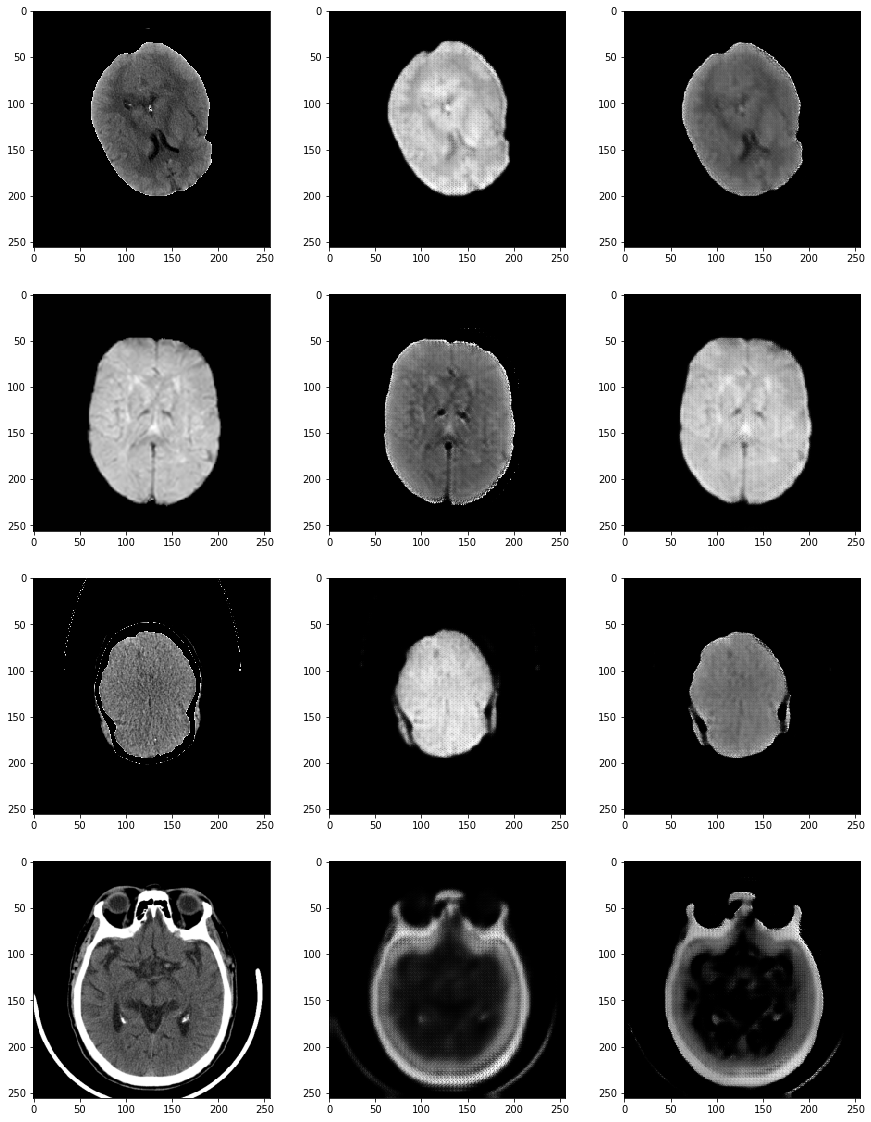

In [103]:
test_images_A = opt['A_train'][1]
test_images_B = opt['B_train'][1]
print(opt['A_train'].shape)
print(opt['B_train'].shape)

synthetic_images_B = model['G_A2B'].predict(test_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

synthetic_images_A = model['G_B2A'].predict(test_images_B[np.newaxis,:])
reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)

plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(test_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")

plt.subplot(4,3,4)
plt.imshow(test_images_B[:,:,0], cmap="gray")
plt.subplot(4,3,5)
plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
plt.subplot(4,3,6)
plt.imshow(reconstructed_image_B[0,:,:,0], cmap="gray")


CTHEALTHY_images_A = opt['CTHEALTHY_images'][1]

synthetic_images_B = model['G_A2B'].predict(CTHEALTHY_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

plt.subplot(4,3,7)
plt.imshow(CTHEALTHY_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,8)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,9)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")


CTFOSCAL_images_A = opt['CTFOSCAL_images'][10]

synthetic_images_B = model['G_A2B'].predict(CTFOSCAL_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

plt.subplot(4,3,10)
plt.imshow(CTFOSCAL_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,11)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,12)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
plt.show()

# Training data

In [104]:
#import keras
#from tensorflow.keras.utils import plot_model
#tf.keras.utils.plot_model(model)

In [105]:
import keras
import seaborn as sns

capa_o = keras.models.Model(inputs=model["G_A2B"].get_input_at(0), outputs=model["G_A2B"].get_layer('add12').output)
capa_o2 = keras.models.Model(inputs=model["G_B2A"].get_input_at(0), outputs=model["G_B2A"].get_layer('add12').output)

In [106]:
synthetic_images_B = model['G_A2B'].predict(opt['A_train'])

synthetic_images_B_CTHEALTHY = model['G_A2B'].predict(opt['CTHEALTHY_images'])
synthetic_images_B_CTFOSCAL = model['G_A2B'].predict(opt['CTFOSCAL_images'])

print(opt['trainA_image_names'][0])
print(opt['CTHEALTHY_image_names'][0])
print(opt['CTFOSCAL_image_names'][0])

emb = capa_o.predict(synthetic_images_B)
print(emb[:,0,0,:].shape, emb.shape)

emb2 = capa_o2.predict(opt['B_train'])
print(emb2[:,0,0,:].shape)

emb3 = capa_o2.predict(synthetic_images_B_CTHEALTHY)
print(emb3[:,0,0,:].shape)

emb4 = capa_o2.predict(synthetic_images_B_CTFOSCAL)
print(emb4[:,0,0,:].shape)

339336-frame1.png
sub-0001_ct-frame152.png
ACV-001_CT_30112021_I00007.png
(502, 128) (502, 64, 64, 128)
(993, 128)
(1568, 128)
(73, 128)


## PCA 2 COMPONENTS

In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb[:,0,0,:])

pca2 = PCA(n_components=2)
comp2 = pca2.fit_transform(emb2[:,0,0,:])

pca3 = PCA(n_components=2)
comp3 = pca3.fit_transform(emb3[:,0,0,:])

pca4 = PCA(n_components=2)
comp4 = pca4.fit_transform(emb4[:,0,0,:])

# Synthetic MRI space

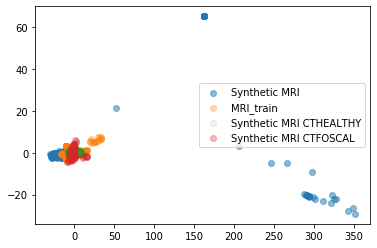

In [111]:
plt.scatter(comp[:,0], comp[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(comp2[:,0], comp2[:,1], label="MRI_train", alpha=0.3)
plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.1)
plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.3)
#plt.xlim((-50,50))
#plt.ylim((-20,20))
plt.legend()
plt.show()

In [ ]:
import umap

print(emb.shape)
print(emb2.shape)
um = umap.UMAP().fit_transform(emb[:,0,0,:])
um2 = umap.UMAP().fit_transform(emb2[:,0,0,:])
um3 = umap.UMAP().fit_transform(emb3[:,0,0,:])
um4 = umap.UMAP().fit_transform(emb4[:,0,0,:])

plt.scatter(um[:,0], um[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(um2[:,0], um2[:,1], label="MRI_train", alpha=0.5)
plt.scatter(um3[:,0], um3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.5)
plt.scatter(um4[:,0], um4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.5)
plt.legend()
plt.show()

## Ischemic lesion (Stroke) / no-Stroke over Synthetic MRI space

In [149]:
import pandas as pd
import seaborn as sns
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp[i,0], comp[i,1]])
    else:
        mb_synth_stroke.append([comp[i,0], comp[i,1]])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)


#CENTROIDES
c_stroke = np.mean(mb_synth_stroke, axis=0)
c_ns = np.mean(mb_synth_ns, axis=0)
c_h = np.mean(comp3, axis=0)
print(c_stroke)
print(c_ns)
print(c_h)
#for i in mb_synth_stroke.shape[0]:
#    mb_synth_stroke[:,0]


#d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = pd.DataFrame(data=d)

#sns.set(rc={'figure.figsize':(8,5)})
#sns.scatterplot(data=d, x="x_pca", y="y_pca", hue="maskbin", alpha=0.9)
plt.figure(figsize=(10,6))

plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="1 (stroke) Synthetic", alpha=0.3, s=20, marker=".", color="#FF6600")
plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="0 (negative) Synthetic", alpha=0.6, s=20, marker=".", color="#0000FF")
plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.1, s=20, marker=".", color="#00AA00")
plt.scatter(c_stroke[0], c_stroke[1], label="", alpha=1, s=100, marker="x", color="#FF3300")
plt.scatter(c_ns[0], c_ns[1], label="", alpha=1, s=100, marker="x", color="#0000FF")
plt.scatter(c_h[0], c_h[1], label="", alpha=1, s=100, marker="x", color="#146d01")
plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.8, s=5, color="#FF0000")
#plt.xticks(np.arange(-3, 20, 1))
plt.xlim((-50,50))
plt.ylim((-20,20))
plt.legend(framealpha=0.5)
plt.show()

339336-frame1.png
<class 'numpy.ndarray'>
[-21.264742   -0.9038705]
[33.199013   1.4111428]
[ 1.5183979e-06 -6.3006823e-08]


In [ ]:
for k in range(d.shape[0]):
    if(d.iloc[k]["x_pca"]>-2 and d.iloc[k]["x_pca"]<-1 and d.iloc[k]["y_pca"]>0 and d.iloc[k]["y_pca"]<2
       and d.iloc[k]["maskbin"]==1):
        print(d.iloc[k]["maskbin"], d.iloc[k]["x_pca"], d.iloc[k]["y_pca"], d.iloc[k]["files"])

<br><br><br>

## PCA 3 COMPONENTS

In [113]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
comp_3d = pca.fit_transform(emb[:,0,0,:])

#pca2 = PCA(n_components=3)
#comp2 = pca2.fit_transform(emb2[:,0,0,:])

pca3 = PCA(n_components=3)
comp3_3d = pca3.fit_transform(emb3[:,0,0,:])

pca4 = PCA(n_components=3)
comp4_3d = pca4.fit_transform(emb4[:,0,0,:])

339336-frame1.png
<class 'numpy.ndarray'>


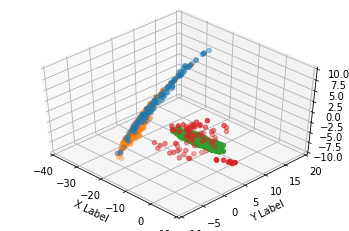

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp_3d[i,0], comp_3d[i,1], comp_3d[i,2]])
    else:
        mb_synth_stroke.append([comp_3d[i,0], comp_3d[i,1], comp_3d[i,2]])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)


#d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp_3d[:,0], 'y_pca': comp_3d[:,1], 'z_pca': comp_3d[:,2]}
d = pd.DataFrame(data=d)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], mb_synth_ns[:,2], marker=m)
ax.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], mb_synth_stroke[:,2], marker=m)
ax.scatter(comp3_3d[:,0], comp3_3d[:,1], comp3_3d[:,2], marker=m)
ax.scatter(comp4_3d[:,0], comp4_3d[:,1], comp4_3d[:,2], marker=m)

ax.set_xlim((-40,10))
ax.set_ylim((-10,20))
ax.set_zlim((-10,10))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(45, -45)

plt.show()

### UMAP

In [ ]:
import umap

print(emb.shape)
print(emb2.shape)
um = umap.UMAP().fit_transform(emb[:,0,0,:])
um2 = umap.UMAP().fit_transform(emb2[:,0,0,:])
um3 = umap.UMAP().fit_transform(emb3[:,0,0,:])
um4 = umap.UMAP().fit_transform(emb4[:,0,0,:])

plt.scatter(um[:,0], um[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(um2[:,0], um2[:,1], label="MRI_train", alpha=0.5)
plt.scatter(um3[:,0], um3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.5)
plt.scatter(um4[:,0], um4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []

for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])

d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = pd.DataFrame(data=d)
#d.head()
#d.to_csv('pd-maskbin-'+str(ep)+'epoch.csv')

#sns.scatterplot(data=d, x="x_pca", y="y_pca", hue="maskbin")
sns.set(rc={'figure.figsize':(8,5)})
sns.scatterplot(data=d, x="x_umap", y="y_umap", hue="maskbin", alpha=0.6)
